# Mask R-CNN - Train on Cobb Water Inlet Dataset

This notebook shows how to train Cobb County water inlet in one image tile on Mask R-CNN. There are 1764 image dataset with ground truth labels that was extracted from urban feature class water Inlet. 140 validation image dataset.

Using ArcGIS Pro "Export trainging data to deeplearning" tools to prepare images and labels

<img src="..\..\images\inlettraing.png" style="width:781px;height:432;">

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import skimage.io 
import skimage.transform as trans

from skimage.io import imread,imsave, imshow, imread_collection, concatenate_images
from skimage.transform import resize
from skimage.morphology import label
import glob
#import pandas as pd
import gdal
# Root directory of the project
ROOT_DIR = os.path.abspath("../../")
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
# Import Mask RCNN

from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log
import keras.backend as K

#from samples.building import building
%matplotlib inline 

C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.i

In [2]:
# Dataset directory
DATASET_DIR = r"C:\projects\landClassification\inletMRCNN"  #os.path.join(ROOT_DIR, "datasets/nucleus")
DATASET_DIRVAL= r"C:\projects\landClassification\inletMRCNNVAL"  #os.path.join(ROOT_DIR, "datasets/nucleus")
print (DATASET_DIR)

C:\projects\landClassification\inletMRCNN


In [3]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [4]:
class cobbConfig(Config):
    """Configuration for training on MS imagenet.
    Derives from the base Config class and overrides values specific
    to the COCO dataset.
    """
    # Give the configuration a recognizable name
    NAME = "cobb"
    
    # We use a GPU with 12GB memory, which can fit two images.
    # Adjust down if you use a smaller GPU.
    IMAGES_PER_GPU = 1
    RPN_ANCHOR_SCALES = (8, 16, 32, 64, 128)
    # Uncomment to train on 8 GPUs (default is 1)
    # GPU_COUNT = 8
    DETECTION_MIN_CONFIDENCE = 0.90
    
    # Number of classes (including background)
    NUM_CLASSES = 1 + 1  # Background + cobb building
    IMAGE_MAX_DIM=512
    IMAGE_MIN_DIM=512
    STEPS_PER_EPOCH = 200
    VALIDATION_STEPS = 50
    
config = cobbConfig()
print (config.IMAGE_SHAPE)
config.display()

[512 512   3]

Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.9
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  512
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  512
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [512 512   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_class_loss': 1.0, 'mrcnn_bbox_loss': 1.0, 'mrcnn_mask_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAP

In [5]:
class cobbDataset(utils.Dataset):
    def load_cobb(self, dataset_dir):
        """Load a subset of the Cobb dataset.
        dataset_dir: The root directory of the pictometry dataset.
        class_ids: If provided, only loads images that have the given classes.
        class_map: TODO: Not implemented yet. Supports maping classes from
            different datasets to the same class ID.
         Load a subset of the Cobb dataset from the given dataset_dir.
        """
        # Add classes
        self.add_class("cobb", 1, "inlet")
        #loading images
        self._image_dir = os.path.join(dataset_dir, "images/")
        self._mask_dir = os.path.join(dataset_dir, "labels/")
        i=0
        for f in glob.glob(os.path.join(self._image_dir, "*.tif")):
            filename = os.path.split(f)[1]
            self.add_image("cobb", image_id=i, path=f,
                          width=config.IMAGE_SHAPE[0], height=config.IMAGE_SHAPE[1], filename=filename)
            i += 1
            if i>3800:
                break
            #print (filename)
            
    def load_mask(self, image_id):
        """Load instance masks for the given image.

        Different datasets use different ways to store masks. This
        function converts the different mask format to one format
        in the form of a bitmap [height, width, instances].

        Returns:
        masks: A bool array of shape [height, width, instance count] with
            one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
        # If not a COCO image, delegate to parent class.
        """Read instance masks for an image.
        Returns:
        masks: A bool array of shape [height, width, instance count] with one mask per instance.
        class_ids: a 1D array of class IDs of the instance masks.
        """
#        self._mask_dir = os.path.join(dataset_dir, "labels/")
        info = self.image_info[image_id]
        fname = info["filename"]
        masks = []
        class_ids = []
        #looping through all the classes, loading and processing corresponding masks
#         for ci in self.class_info:
#             class_name = ci["name"]
#             class_id = ci["id"]
#             try:
        m_src = skimage.io.imread(os.path.join(self._mask_dir, "1", fname))
#            except:
                #no file with masks of this class found
#                continue                
            #making individual masks for each instance
        instance_ids = np.unique(m_src)
        print (instance_ids)
        for i in instance_ids:
            if i > 0:
                m = np.zeros(m_src.shape)
                m[m_src==i] = i
                print(i)
                if np.any(m==i):
                    masks.append(m)
#                        class_ids.append(class_id)
        try:
            masks = np.stack(masks, axis=-1)        
        except:
            print("!There were no mask.", info)
            
        # Return mask, and array of class IDs of each instance.
        return masks.astype(np.bool), np.ones([masks.shape[-1]], dtype=np.int32)
    
    def image_reference(self, image_id):
        """Return a link to the image in the COCO Website."""
        info = self.image_info[image_id]
        if info["source"] == "cobb":
            return info["cobb"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [6]:
# Load dataset
dataset = cobbDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset.load_cobb(DATASET_DIR)

# Must call before using the dataset
dataset.prepare()
print("Image Count: {}".format(len(dataset.image_ids)))
print("Class Count: {}".format(dataset.num_classes))
for i, info in enumerate(dataset.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 1764
Class Count: 2
  0. BG                                                
  1. inlet                                             


521
[0 1 2 3]
1
2
3


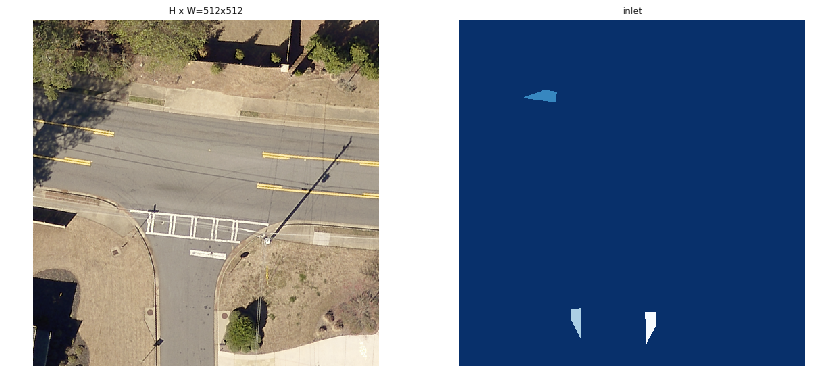

83
[0 1]
1


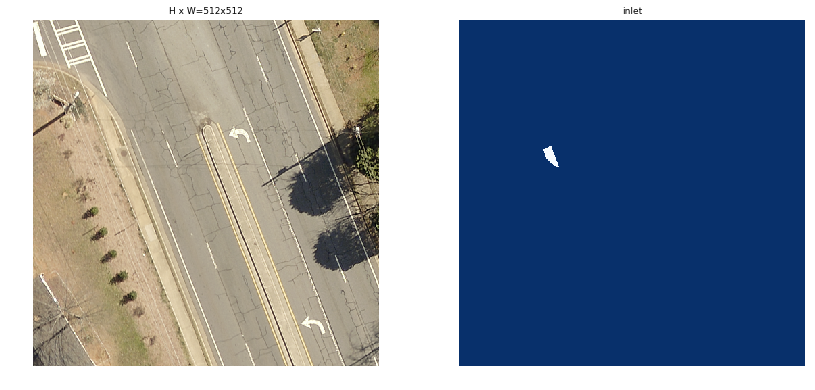

343
[0 1]
1


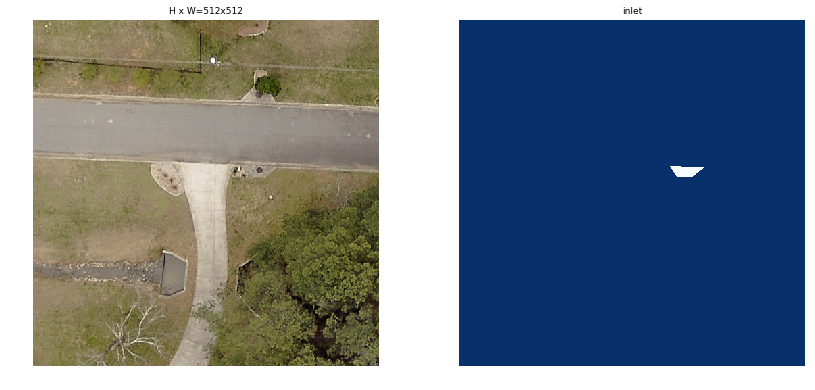

1595
[0 1 2]
1
2


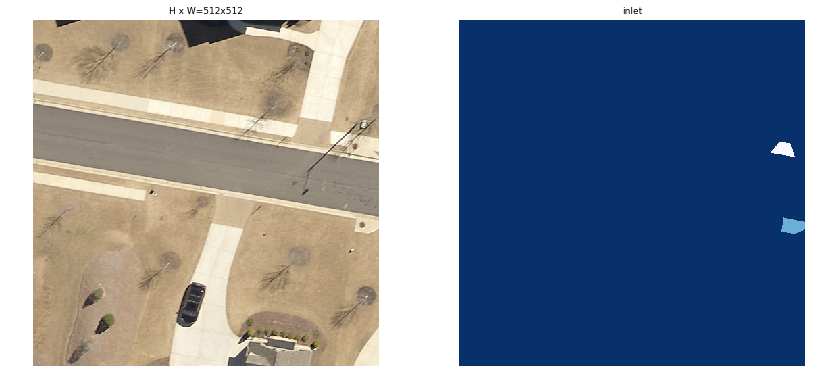

In [17]:
image_ids = np.random.choice(dataset.image_ids,4)
#print (image_ids)
for image_id in image_ids:
    print (image_id)
    image = dataset.load_image(image_id)
    mask, class_ids = dataset.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset.class_names,limit=1)

In [7]:
dataset_val = cobbDataset()
# The subset is the name of the sub-directory, such as stage1_train,
# stage1_test, ...etc. You can also use these special values:
#     train: loads stage1_train but excludes validation images
#     val: loads validation images from stage1_train. For a list
#          of validation images see nucleus.py
dataset_val.load_cobb(DATASET_DIRVAL)
# Must call before using the dataset
dataset_val.prepare()
print("Image Count: {}".format(len(dataset_val.image_ids)))
print("Class Count: {}".format(dataset_val.num_classes))
for i, info in enumerate(dataset_val.class_info):
    print("{:3}. {:50}".format(i, info['name']))

Image Count: 140
Class Count: 2
  0. BG                                                
  1. inlet                                             


In [8]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=DATASET_DIR)







Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
box_ind is deprecated, use box_indices instead


In [9]:
# Which weights to start with?
init_with = "imagenet"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc", 
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

In [10]:
# Train the head branches
# Passing layers="heads" freezes all layers except the head
# layers. You can also pass a regular expression to select
# which layers to train by name pattern.
model.train(dataset, dataset_val, 
            learning_rate=config.LEARNING_RATE*2, 
            epochs=1, 
            layers='heads')


Starting at epoch 0. LR=0.002

Checkpoint Path: C:\projects\landClassification\inletMRCNN\cobb20200223T2101\mask_rcnn_cobb_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4       (TimeDistributed)

C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "




Epoch 1/1
[0 1]
1
  1/200 [..............................] - ETA: 46:23 - loss: 5.6332 - rpn_class_loss: 3.3638 - rpn_bbox_loss: 1.8767 - mrcnn_class_loss: 0.3926 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00[0 1 2]
1
2
  2/200 [..............................] - ETA: 40:54 - loss: 4.6326 - rpn_class_loss: 2.7494 - rpn_bbox_loss: 1.6255 - mrcnn_class_loss: 0.2577 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00[0 1]
1
  3/200 [..............................] - ETA: 39:15 - loss: 4.1896 - rpn_class_loss: 2.2469 - rpn_bbox_loss: 1.7219 - mrcnn_class_loss: 0.2208 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00[0 1 2]
1
2
  4/200 [..............................] - ETA: 38:08 - loss: 3.6027 - rpn_class_loss: 1.7658 - rpn_bbox_loss: 1.6607 - mrcnn_class_loss: 0.1763 - mrcnn_bbox_loss: 0.0000e+00 - mrcnn_mask_loss: 0.0000e+00[0 1]
1
  5/200 [..............................] - ETA: 37:36 - loss: 3.2464 - rpn_class_loss: 1.4450 - rpn_bbox_loss: 1.6528 - mrcn

 78/200 [==========>...................] - ETA: 21:52 - loss: 3.0470 - rpn_class_loss: 0.1442 - rpn_bbox_loss: 2.4890 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.2861 - mrcnn_mask_loss: 0.1109[0 1 2]
1
2
 79/200 [==========>...................] - ETA: 21:41 - loss: 3.0377 - rpn_class_loss: 0.1429 - rpn_bbox_loss: 2.4862 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2825 - mrcnn_mask_loss: 0.1095[0 1 2]
1
2
 80/200 [===========>..................] - ETA: 21:31 - loss: 3.0302 - rpn_class_loss: 0.1420 - rpn_bbox_loss: 2.4619 - mrcnn_class_loss: 0.0175 - mrcnn_bbox_loss: 0.2917 - mrcnn_mask_loss: 0.1171[0 1 2]
1
2
 81/200 [===========>..................] - ETA: 21:20 - loss: 3.0149 - rpn_class_loss: 0.1408 - rpn_bbox_loss: 2.4529 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2881 - mrcnn_mask_loss: 0.1157[0 1]
1
 82/200 [===========>..................] - ETA: 21:09 - loss: 3.0458 - rpn_class_loss: 0.1394 - rpn_bbox_loss: 2.4495 - mrcnn_class_loss: 0.0174 - mrcnn_bbox_loss: 0.3164 -

156/200 [======================>.......] - ETA: 7:51 - loss: 2.6565 - rpn_class_loss: 0.0954 - rpn_bbox_loss: 1.9673 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.1866[0 1]
1
157/200 [======================>.......] - ETA: 7:40 - loss: 2.6556 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 1.9579 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.3991 - mrcnn_mask_loss: 0.1898[0 1]
1
158/200 [======================>.......] - ETA: 7:30 - loss: 2.6487 - rpn_class_loss: 0.0949 - rpn_bbox_loss: 1.9549 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.3966 - mrcnn_mask_loss: 0.1886[0 1]
1
159/200 [======================>.......] - ETA: 7:19 - loss: 2.6462 - rpn_class_loss: 0.0945 - rpn_bbox_loss: 1.9472 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.3990 - mrcnn_mask_loss: 0.1918[0 1]
1
160/200 [=======================>......] - ETA: 7:08 - loss: 2.6420 - rpn_class_loss: 0.0941 - rpn_bbox_loss: 1.9472 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.3965 - mrcnn_mask_loss:

In [14]:
history = model.keras_model.history.history

In [11]:
%%time
model.train(dataset, dataset_val, 
            learning_rate=config.LEARNING_RATE*2, 
            epochs=58, 
            layers='all')
new_history=model.keras_model.history.history
for k in new_history:history[k]=history[k]+new_history[k]


Starting at epoch 1. LR=0.002

Checkpoint Path: C:\projects\landClassification\inletMRCNN\cobb20200223T2101\mask_rcnn_cobb_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_branch2b         (Conv2D)

C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
C:\Users\zhangc\AppData\Local\Continuum\anaconda3\envs\maskrcnn\lib\site-packages\tensorflow\python\ops\gradients_util.py:93: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 2/58
[0 1 2]
1
2
  1/200 [..............................] - ETA: 1:18:10 - loss: 2.8921 - rpn_class_loss: 0.0366 - rpn_bbox_loss: 1.1310 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 1.0043 - mrcnn_mask_loss: 0.7086[0 1 2]
1
2
  2/200 [..............................] - ETA: 1:00:57 - loss: 2.8128 - rpn_class_loss: 0.0395 - rpn_bbox_loss: 1.2159 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.8345 - mrcnn_mask_loss: 0.7080[0 1]
1
  3/200 [..............................] - ETA: 54:57 - loss: 2.1156 - rpn_class_loss: 0.0347 - rpn_bbox_loss: 1.0420 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.5563 - mrcnn_mask_loss: 0.4720  [0 1]
1
  4/200 [..............................] - ETA: 51:58 - loss: 2.3562 - rpn_class_loss: 0.0317 - rpn_bbox_loss: 1.0978 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.6987 - mrcnn_mask_loss: 0.5144[0 1]
1
  5/200 [..............................] - ETA: 50:08 - loss: 2.7749 - rpn_class_loss: 0.0328 - rpn_bbox_loss: 1.7607 - mrcnn_class_loss: 0.0109 - mrcn

 79/200 [==========>...................] - ETA: 27:07 - loss: 1.9925 - rpn_class_loss: 0.0376 - rpn_bbox_loss: 1.2625 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.4036 - mrcnn_mask_loss: 0.2758[0 1]
1
 80/200 [===========>..................] - ETA: 26:53 - loss: 1.9925 - rpn_class_loss: 0.0377 - rpn_bbox_loss: 1.2566 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.4039 - mrcnn_mask_loss: 0.2813[0 1]
1
 81/200 [===========>..................] - ETA: 26:39 - loss: 2.0083 - rpn_class_loss: 0.0381 - rpn_bbox_loss: 1.2639 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.4061 - mrcnn_mask_loss: 0.2870[0 1]
1
 82/200 [===========>..................] - ETA: 26:25 - loss: 2.0269 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.2677 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.4151 - mrcnn_mask_loss: 0.2922[0 1 2]
1
2
 83/200 [===========>..................] - ETA: 26:12 - loss: 2.0312 - rpn_class_loss: 0.0384 - rpn_bbox_loss: 1.2804 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.4101 - mrcnn_m

157/200 [======================>.......] - ETA: 9:34 - loss: 1.8048 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 1.1508 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3462 - mrcnn_mask_loss: 0.2592[0 1]
1
158/200 [======================>.......] - ETA: 9:21 - loss: 1.8113 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 1.1517 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3490 - mrcnn_mask_loss: 0.2620[0 1]
1
159/200 [======================>.......] - ETA: 9:07 - loss: 1.8061 - rpn_class_loss: 0.0383 - rpn_bbox_loss: 1.1505 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3468 - mrcnn_mask_loss: 0.2604[0 1]
1
160/200 [=======================>......] - ETA: 8:54 - loss: 1.7991 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.1473 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.3447 - mrcnn_mask_loss: 0.2588[0 1]
1
161/200 [=======================>......] - ETA: 8:40 - loss: 1.8012 - rpn_class_loss: 0.0382 - rpn_bbox_loss: 1.1532 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.3425 - mrcnn_mask_loss:

 33/200 [===>..........................] - ETA: 42:19 - loss: 1.5599 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.7983 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.4055 - mrcnn_mask_loss: 0.3152[0 1 2]
1
2
 34/200 [====>.........................] - ETA: 42:04 - loss: 1.5519 - rpn_class_loss: 0.0329 - rpn_bbox_loss: 0.8115 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.3936 - mrcnn_mask_loss: 0.3060[0 1 2]
1
2
 35/200 [====>.........................] - ETA: 41:50 - loss: 1.5553 - rpn_class_loss: 0.0332 - rpn_bbox_loss: 0.7991 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.3978 - mrcnn_mask_loss: 0.3172[0 1]
1
 36/200 [====>.........................] - ETA: 41:34 - loss: 1.5241 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.7878 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.3868 - mrcnn_mask_loss: 0.3084[0 1]
1
 37/200 [====>.........................] - ETA: 41:19 - loss: 1.5650 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.8056 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.3989 - mrc

111/200 [===============>..............] - ETA: 22:37 - loss: 1.5215 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.8974 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.3139 - mrcnn_mask_loss: 0.2686[0 1]
1
112/200 [===============>..............] - ETA: 22:22 - loss: 1.5112 - rpn_class_loss: 0.0348 - rpn_bbox_loss: 0.8924 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.3111 - mrcnn_mask_loss: 0.2662[0 1]
1
113/200 [===============>..............] - ETA: 22:07 - loss: 1.5008 - rpn_class_loss: 0.0349 - rpn_bbox_loss: 0.8871 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.3083 - mrcnn_mask_loss: 0.2639[0 1 2]
1
2
114/200 [================>.............] - ETA: 21:51 - loss: 1.4965 - rpn_class_loss: 0.0351 - rpn_bbox_loss: 0.8876 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.3056 - mrcnn_mask_loss: 0.2616[0 1 2]
1
2
115/200 [================>.............] - ETA: 21:36 - loss: 1.4888 - rpn_class_loss: 0.0352 - rpn_bbox_loss: 0.8848 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.3029 - mrc

190/200 [===========================>..] - ETA: 2:32 - loss: 1.4774 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.8711 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.2998 - mrcnn_mask_loss: 0.2626[0 1 2]
1
2
191/200 [===========================>..] - ETA: 2:17 - loss: 1.4737 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.8703 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.2983 - mrcnn_mask_loss: 0.2612[0 1 2]
1
2
192/200 [===========================>..] - ETA: 2:02 - loss: 1.4766 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.8682 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.3009 - mrcnn_mask_loss: 0.2634[0 1 2]
1
2
193/200 [===========================>..] - ETA: 1:46 - loss: 1.4831 - rpn_class_loss: 0.0369 - rpn_bbox_loss: 0.8706 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.3029 - mrcnn_mask_loss: 0.2656[0 1 2]
1
2
194/200 [============================>.] - ETA: 1:31 - loss: 1.4790 - rpn_class_loss: 0.0368 - rpn_bbox_loss: 0.8694 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.3013 - 

 66/200 [========>.....................] - ETA: 33:56 - loss: 1.4560 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.8343 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.3202 - mrcnn_mask_loss: 0.2615[0 1]
1
 67/200 [=========>....................] - ETA: 33:41 - loss: 1.4812 - rpn_class_loss: 0.0325 - rpn_bbox_loss: 0.8425 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.3304 - mrcnn_mask_loss: 0.2681[0 1 2]
1
2
 68/200 [=========>....................] - ETA: 33:25 - loss: 1.4797 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.8499 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.3255 - mrcnn_mask_loss: 0.2642[0 1]
1
 69/200 [=========>....................] - ETA: 33:10 - loss: 1.4683 - rpn_class_loss: 0.0323 - rpn_bbox_loss: 0.8472 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.3208 - mrcnn_mask_loss: 0.2603[0 1]
1
 70/200 [=========>....................] - ETA: 32:55 - loss: 1.4622 - rpn_class_loss: 0.0322 - rpn_bbox_loss: 0.8497 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.3162 - mrcnn_m

144/200 [====================>.........] - ETA: 14:12 - loss: 1.4476 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7788 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.3225 - mrcnn_mask_loss: 0.3054[0 1 2 3 4]
1
2
3
4
145/200 [====================>.........] - ETA: 13:56 - loss: 1.4540 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.7785 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.3262 - mrcnn_mask_loss: 0.3082[0 1]
1
146/200 [====================>.........] - ETA: 13:41 - loss: 1.4532 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7821 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.3240 - mrcnn_mask_loss: 0.3061[0 1]
1
147/200 [=====================>........] - ETA: 13:26 - loss: 1.4451 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7784 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.3218 - mrcnn_mask_loss: 0.3040[0 1]
1
148/200 [=====================>........] - ETA: 13:11 - loss: 1.4457 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7833 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.3196 -

 19/200 [=>............................] - ETA: 45:42 - loss: 1.5758 - rpn_class_loss: 0.0326 - rpn_bbox_loss: 0.8631 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.3141 - mrcnn_mask_loss: 0.3571[0 1 2]
1
2
 20/200 [==>...........................] - ETA: 45:28 - loss: 1.5734 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.8453 - mrcnn_class_loss: 0.0091 - mrcnn_bbox_loss: 0.3139 - mrcnn_mask_loss: 0.3728[0 1]
1
 21/200 [==>...........................] - ETA: 45:13 - loss: 1.6542 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.9574 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.2990 - mrcnn_mask_loss: 0.3550[0 1]
1
 22/200 [==>...........................] - ETA: 44:58 - loss: 1.6826 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.9414 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.3283 - mrcnn_mask_loss: 0.3706[0 1]
1
 23/200 [==>...........................] - ETA: 44:45 - loss: 1.6658 - rpn_class_loss: 0.0331 - rpn_bbox_loss: 0.9110 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.3293 - mrcnn_m

 97/200 [=============>................] - ETA: 26:03 - loss: 1.3259 - rpn_class_loss: 0.0337 - rpn_bbox_loss: 0.7660 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.2409 - mrcnn_mask_loss: 0.2790[0 1 2]
1
2
 98/200 [=============>................] - ETA: 25:47 - loss: 1.3230 - rpn_class_loss: 0.0339 - rpn_bbox_loss: 0.7682 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.2762[0 1]
1
 99/200 [=============>................] - ETA: 25:32 - loss: 1.3237 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.7740 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.2360 - mrcnn_mask_loss: 0.2734[0 1]
1
100/200 [==============>...............] - ETA: 25:17 - loss: 1.3230 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.7785 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.2337 - mrcnn_mask_loss: 0.2707[0 1 2]
1
2
101/200 [==============>...............] - ETA: 25:02 - loss: 1.3329 - rpn_class_loss: 0.0340 - rpn_bbox_loss: 0.7757 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.2425 - mrc

176/200 [=========================>....] - ETA: 6:04 - loss: 1.3090 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.7454 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.2372 - mrcnn_mask_loss: 0.2870[0 1]
1
177/200 [=========================>....] - ETA: 5:49 - loss: 1.3050 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.7444 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.2853[0 1]
1
178/200 [=========================>....] - ETA: 5:33 - loss: 1.3056 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.7481 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.2346 - mrcnn_mask_loss: 0.2837[0 1 2]
1
2
179/200 [=========================>....] - ETA: 5:18 - loss: 1.3015 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.7469 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.2821[0 1]
1
180/200 [==========================>...] - ETA: 5:03 - loss: 1.2965 - rpn_class_loss: 0.0333 - rpn_bbox_loss: 0.7449 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.2320 - mrcnn_mask_l

 51/200 [======>.......................] - ETA: 37:38 - loss: 1.2855 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.8663 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.1759 - mrcnn_mask_loss: 0.2063[0 1]
1
 52/200 [======>.......................] - ETA: 37:23 - loss: 1.2808 - rpn_class_loss: 0.0341 - rpn_bbox_loss: 0.8689 - mrcnn_class_loss: 0.0029 - mrcnn_bbox_loss: 0.1725 - mrcnn_mask_loss: 0.2023[0 1]
1
 53/200 [======>.......................] - ETA: 37:08 - loss: 1.2636 - rpn_class_loss: 0.0342 - rpn_bbox_loss: 0.8588 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.1985[0 1]
1
 54/200 [=======>......................] - ETA: 36:53 - loss: 1.3237 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.9240 - mrcnn_class_loss: 0.0028 - mrcnn_bbox_loss: 0.1661 - mrcnn_mask_loss: 0.1949[0 1]
1
 55/200 [=======>......................] - ETA: 36:38 - loss: 1.3203 - rpn_class_loss: 0.0356 - rpn_bbox_loss: 0.9275 - mrcnn_class_loss: 0.0027 - mrcnn_bbox_loss: 0.1631 - mrcnn_mask_

129/200 [==================>...........] - ETA: 17:57 - loss: 1.3817 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.8754 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.2354 - mrcnn_mask_loss: 0.2335[0 1]
1
130/200 [==================>...........] - ETA: 17:42 - loss: 1.3740 - rpn_class_loss: 0.0335 - rpn_bbox_loss: 0.8713 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.2317[0 1]
1
131/200 [==================>...........] - ETA: 17:27 - loss: 1.3805 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.8710 - mrcnn_class_loss: 0.0038 - mrcnn_bbox_loss: 0.2374 - mrcnn_mask_loss: 0.2349[0 1 2]
1
2
132/200 [==================>...........] - ETA: 17:11 - loss: 1.3836 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.8678 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.2405 - mrcnn_mask_loss: 0.2380[0 1]
1
133/200 [==================>...........] - ETA: 16:56 - loss: 1.3823 - rpn_class_loss: 0.0334 - rpn_bbox_loss: 0.8702 - mrcnn_class_loss: 0.0039 - mrcnn_bbox_loss: 0.2387 - mrcnn_m

  4/200 [..............................] - ETA: 49:01 - loss: 1.3248 - rpn_class_loss: 0.0358 - rpn_bbox_loss: 0.6319 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.3280 - mrcnn_mask_loss: 0.3217[0 1 2]
1
2
  5/200 [..............................] - ETA: 48:48 - loss: 1.2066 - rpn_class_loss: 0.0365 - rpn_bbox_loss: 0.6443 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.2624 - mrcnn_mask_loss: 0.2574[0 1 2]
1
2
  6/200 [..............................] - ETA: 48:34 - loss: 1.3488 - rpn_class_loss: 0.0346 - rpn_bbox_loss: 0.6363 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.3625 - mrcnn_mask_loss: 0.3080[0 1]
1
  7/200 [>.............................] - ETA: 48:20 - loss: 1.1932 - rpn_class_loss: 0.0338 - rpn_bbox_loss: 0.5784 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.3107 - mrcnn_mask_loss: 0.2640[0 1]
1
  8/200 [>.............................] - ETA: 48:09 - loss: 1.0655 - rpn_class_loss: 0.0324 - rpn_bbox_loss: 0.5247 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.2719 - mrc

 82/200 [===========>..................] - ETA: 29:47 - loss: 1.2745 - rpn_class_loss: 0.0306 - rpn_bbox_loss: 0.7186 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.2370 - mrcnn_mask_loss: 0.2825[0 1]
1
 83/200 [===========>..................] - ETA: 29:32 - loss: 1.2706 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.7211 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.2342 - mrcnn_mask_loss: 0.2791[0 1]
1
 84/200 [===========>..................] - ETA: 29:16 - loss: 1.2635 - rpn_class_loss: 0.0305 - rpn_bbox_loss: 0.7201 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2758[0 1]
1
 85/200 [===========>..................] - ETA: 29:01 - loss: 1.2665 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.7200 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.2314 - mrcnn_mask_loss: 0.2791[0 1]
1
 86/200 [===========>..................] - ETA: 28:46 - loss: 1.2578 - rpn_class_loss: 0.0304 - rpn_bbox_loss: 0.7172 - mrcnn_class_loss: 0.0056 - mrcnn_bbox_loss: 0.2287 - mrcnn_mask_

122/200 [=================>............] - ETA: 19:42 - loss: 1.2068 - rpn_class_loss: 0.0309 - rpn_bbox_loss: 0.7445 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.2305[0 1 2 3]
1
2
3
123/200 [=================>............] - ETA: 19:26 - loss: 1.2032 - rpn_class_loss: 0.0311 - rpn_bbox_loss: 0.7441 - mrcnn_class_loss: 0.0045 - mrcnn_bbox_loss: 0.1948 - mrcnn_mask_loss: 0.2287[0 1]
1
124/200 [=================>............] - ETA: 19:11 - loss: 1.1963 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.7406 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.1933 - mrcnn_mask_loss: 0.2268[0 1 2]
1
2
125/200 [=================>............] - ETA: 18:56 - loss: 1.1897 - rpn_class_loss: 0.0313 - rpn_bbox_loss: 0.7372 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.1917 - mrcnn_mask_loss: 0.2250[0 1]
1
126/200 [=================>............] - ETA: 18:41 - loss: 1.1911 - rpn_class_loss: 0.0312 - rpn_bbox_loss: 0.7328 - mrcnn_class_loss: 0.0044 - mrcnn_bbox_loss: 0.1951 -

[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
200/200 [==============================] - 3260s 16s/step - loss: 1.3083 - rpn_class_loss: 0.0302 - rpn_bbox_loss: 0.6828 - mrcnn_class_loss: 0.0067 - mrcnn_bbox_loss: 0.2831 - mrcnn_mask_loss: 0.3054 - val_loss: 1.5547 - val_rpn_class_loss: 0.0218 - val_rpn_bbox_loss: 0.5888 - val_mrcnn_class_loss: 0.0129 - val_mrcnn_bbox_loss: 0.4530 - val_mrcnn_mask_loss: 0.4781
Epoch 8/58
[0 1]
1
  1/200 [..............................] - ETA: 49:53 - loss: 1.7302 - rpn_class_loss: 0.0277 - rpn_bbox_loss: 0.2239 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.8184 - mrcnn_mask_loss: 0.6462[0 1]
1
  2/200 [..............................] - ETA: 49:32 - loss: 1.0549 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.2871 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.4092 - 

 77/200 [==========>...................] - ETA: 31:04 - loss: 1.3778 - rpn_class_loss: 0.0256 - rpn_bbox_loss: 0.5440 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.3822 - mrcnn_mask_loss: 0.4163[0 1 2]
1
2
 78/200 [==========>...................] - ETA: 30:48 - loss: 1.3784 - rpn_class_loss: 0.0255 - rpn_bbox_loss: 0.5421 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.3824 - mrcnn_mask_loss: 0.4183[0 1]
1
 79/200 [==========>...................] - ETA: 30:33 - loss: 1.3899 - rpn_class_loss: 0.0254 - rpn_bbox_loss: 0.5449 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.3875 - mrcnn_mask_loss: 0.4220[0 1]
1
 80/200 [===========>..................] - ETA: 30:18 - loss: 1.3981 - rpn_class_loss: 0.0253 - rpn_bbox_loss: 0.5431 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.3935 - mrcnn_mask_loss: 0.4262[0 1]
1
 81/200 [===========>..................] - ETA: 30:03 - loss: 1.3924 - rpn_class_loss: 0.0252 - rpn_bbox_loss: 0.5477 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3887 - mrcnn_m

155/200 [======================>.......] - ETA: 11:22 - loss: 1.4137 - rpn_class_loss: 0.0259 - rpn_bbox_loss: 0.5955 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.3676 - mrcnn_mask_loss: 0.4152[0 1 2]
1
2
156/200 [======================>.......] - ETA: 11:06 - loss: 1.4170 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5978 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.3685 - mrcnn_mask_loss: 0.4154[0 1]
1
157/200 [======================>.......] - ETA: 10:51 - loss: 1.4133 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5946 - mrcnn_class_loss: 0.0095 - mrcnn_bbox_loss: 0.3674 - mrcnn_mask_loss: 0.4159[0 1 2]
1
2
158/200 [======================>.......] - ETA: 10:36 - loss: 1.4155 - rpn_class_loss: 0.0258 - rpn_bbox_loss: 0.5971 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.3672 - mrcnn_mask_loss: 0.4159[0 1 2]
1
2
159/200 [======================>.......] - ETA: 10:21 - loss: 1.4151 - rpn_class_loss: 0.0260 - rpn_bbox_loss: 0.5967 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.3663 -

 30/200 [===>..........................] - ETA: 42:59 - loss: 1.6204 - rpn_class_loss: 0.0281 - rpn_bbox_loss: 0.7411 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.3862 - mrcnn_mask_loss: 0.4500[0 1 2]
1
2
 31/200 [===>..........................] - ETA: 42:44 - loss: 1.6004 - rpn_class_loss: 0.0279 - rpn_bbox_loss: 0.7259 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.3818 - mrcnn_mask_loss: 0.4498[0 1]
1
 32/200 [===>..........................] - ETA: 42:29 - loss: 1.6051 - rpn_class_loss: 0.0274 - rpn_bbox_loss: 0.7223 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.3871 - mrcnn_mask_loss: 0.4531[0 1]
1
 33/200 [===>..........................] - ETA: 42:14 - loss: 1.6636 - rpn_class_loss: 0.0278 - rpn_bbox_loss: 0.8063 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.3754 - mrcnn_mask_loss: 0.4394[0 1]
1
 34/200 [====>.........................] - ETA: 41:58 - loss: 1.6348 - rpn_class_loss: 0.0285 - rpn_bbox_loss: 0.8012 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.3643 - mrcnn_m

108/200 [===============>..............] - ETA: 23:15 - loss: 1.4318 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6359 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.3562 - mrcnn_mask_loss: 0.4016[0 1]
1
109/200 [===============>..............] - ETA: 23:00 - loss: 1.4342 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6369 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.3564 - mrcnn_mask_loss: 0.4029[0 1 2]
1
2
110/200 [===============>..............] - ETA: 22:45 - loss: 1.4311 - rpn_class_loss: 0.0273 - rpn_bbox_loss: 0.6341 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.3557 - mrcnn_mask_loss: 0.4033[0 1]
1
111/200 [===============>..............] - ETA: 22:30 - loss: 1.4412 - rpn_class_loss: 0.0272 - rpn_bbox_loss: 0.6346 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.3622 - mrcnn_mask_loss: 0.4065[0 1]
1
112/200 [===============>..............] - ETA: 22:15 - loss: 1.4396 - rpn_class_loss: 0.0271 - rpn_bbox_loss: 0.6325 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.3629 - mrcnn_m

186/200 [==========================>...] - ETA: 3:32 - loss: 1.3873 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.5830 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.3624 - mrcnn_mask_loss: 0.4055[0 1]
1
187/200 [===========================>..] - ETA: 3:17 - loss: 1.3952 - rpn_class_loss: 0.0266 - rpn_bbox_loss: 0.5950 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3604 - mrcnn_mask_loss: 0.4033[0 1]
1
188/200 [===========================>..] - ETA: 3:02 - loss: 1.3929 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.5931 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3598 - mrcnn_mask_loss: 0.4036[0 1]
1
189/200 [===========================>..] - ETA: 2:47 - loss: 1.3906 - rpn_class_loss: 0.0265 - rpn_bbox_loss: 0.5913 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.3595 - mrcnn_mask_loss: 0.4035[0 1]
1
190/200 [===========================>..] - ETA: 2:31 - loss: 1.3879 - rpn_class_loss: 0.0264 - rpn_bbox_loss: 0.5898 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.3581 - mrcnn_mask_loss:

 61/200 [========>.....................] - ETA: 35:07 - loss: 1.2125 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.5006 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.3496[0 1 2 3 4]
1
2
3
4
 62/200 [========>.....................] - ETA: 34:52 - loss: 1.2266 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5048 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.3370 - mrcnn_mask_loss: 0.3523[0 1]
1
 63/200 [========>.....................] - ETA: 34:37 - loss: 1.2114 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5007 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_loss: 0.3467[0 1]
1
 64/200 [========>.....................] - ETA: 34:22 - loss: 1.2075 - rpn_class_loss: 0.0251 - rpn_bbox_loss: 0.5075 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.3264 - mrcnn_mask_loss: 0.3413[0 1]
1
 65/200 [========>.....................] - ETA: 34:07 - loss: 1.1993 - rpn_class_loss: 0.0249 - rpn_bbox_loss: 0.5009 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.3256 -

139/200 [===================>..........] - ETA: 15:25 - loss: 1.1845 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.4873 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3299 - mrcnn_mask_loss: 0.3337[0 1]
1
140/200 [====================>.........] - ETA: 15:10 - loss: 1.1875 - rpn_class_loss: 0.0236 - rpn_bbox_loss: 0.4892 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.3309 - mrcnn_mask_loss: 0.3337[0 1]
1
141/200 [====================>.........] - ETA: 14:55 - loss: 1.1856 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.4920 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3285 - mrcnn_mask_loss: 0.3314[0 1]
1
142/200 [====================>.........] - ETA: 14:40 - loss: 1.1823 - rpn_class_loss: 0.0238 - rpn_bbox_loss: 0.4893 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.3279 - mrcnn_mask_loss: 0.3314[0 1]
1
143/200 [====================>.........] - ETA: 14:25 - loss: 1.1832 - rpn_class_loss: 0.0237 - rpn_bbox_loss: 0.4885 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.3280 - mrcnn_mask_

179/200 [=========================>....] - ETA: 5:18 - loss: 1.2024 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.4911 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3308 - mrcnn_mask_loss: 0.3471[0 1]
1
180/200 [==========================>...] - ETA: 5:03 - loss: 1.2012 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4896 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3298 - mrcnn_mask_loss: 0.3483[0 1 2]
1
2
181/200 [==========================>...] - ETA: 4:48 - loss: 1.2010 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4883 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.3296 - mrcnn_mask_loss: 0.3496[0 1]
1
182/200 [==========================>...] - ETA: 4:33 - loss: 1.2008 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4877 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.3291 - mrcnn_mask_loss: 0.3506[0 1]
1
183/200 [==========================>...] - ETA: 4:18 - loss: 1.2044 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4876 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.3316 - mrcnn_mask_l

 54/200 [=======>......................] - ETA: 36:53 - loss: 1.1234 - rpn_class_loss: 0.0212 - rpn_bbox_loss: 0.3874 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.3179 - mrcnn_mask_loss: 0.3845[0 1 2]
1
2
 55/200 [=======>......................] - ETA: 36:37 - loss: 1.1426 - rpn_class_loss: 0.0213 - rpn_bbox_loss: 0.3976 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.3256 - mrcnn_mask_loss: 0.3855[0 1]
1
 56/200 [=======>......................] - ETA: 36:22 - loss: 1.1480 - rpn_class_loss: 0.0211 - rpn_bbox_loss: 0.3971 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.3271 - mrcnn_mask_loss: 0.3901[0 1]
1
 57/200 [=======>......................] - ETA: 36:07 - loss: 1.1722 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.4070 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.3356 - mrcnn_mask_loss: 0.3954[0 1 2]
1
2
 58/200 [=======>......................] - ETA: 35:52 - loss: 1.1743 - rpn_class_loss: 0.0216 - rpn_bbox_loss: 0.4045 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.3393 - mrc

132/200 [==================>...........] - ETA: 17:11 - loss: 1.1868 - rpn_class_loss: 0.0215 - rpn_bbox_loss: 0.4106 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.3532 - mrcnn_mask_loss: 0.3887[0 1]
1
133/200 [==================>...........] - ETA: 16:56 - loss: 1.1862 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4093 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.3544 - mrcnn_mask_loss: 0.3883[0 1 2]
1
2
134/200 [===================>..........] - ETA: 16:41 - loss: 1.1821 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4074 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.3530 - mrcnn_mask_loss: 0.3874[0 1 2]
1
2
135/200 [===================>..........] - ETA: 16:26 - loss: 1.1838 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4086 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.3536 - mrcnn_mask_loss: 0.3874[0 1 2 3]
1
2
3
136/200 [===================>..........] - ETA: 16:10 - loss: 1.1843 - rpn_class_loss: 0.0214 - rpn_bbox_loss: 0.4086 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.35

  7/200 [>.............................] - ETA: 48:32 - loss: 1.1691 - rpn_class_loss: 0.0199 - rpn_bbox_loss: 0.4669 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.3206 - mrcnn_mask_loss: 0.3552[0 1]
1
  8/200 [>.............................] - ETA: 48:17 - loss: 1.1441 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.5270 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.2805 - mrcnn_mask_loss: 0.3108[0 1]
1
  9/200 [>.............................] - ETA: 48:00 - loss: 1.1310 - rpn_class_loss: 0.0206 - rpn_bbox_loss: 0.5203 - mrcnn_class_loss: 0.0053 - mrcnn_bbox_loss: 0.2602 - mrcnn_mask_loss: 0.3245[0 1]
1
 10/200 [>.............................] - ETA: 47:52 - loss: 1.0732 - rpn_class_loss: 0.0194 - rpn_bbox_loss: 0.4727 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.2577 - mrcnn_mask_loss: 0.3183[0 1 2 3]
1
2
3
 11/200 [>.............................] - ETA: 47:38 - loss: 1.1045 - rpn_class_loss: 0.0217 - rpn_bbox_loss: 0.4633 - mrcnn_class_loss: 0.0050 - mrcnn_bbox_loss: 0.2799 - mrc

 85/200 [===========>..................] - ETA: 29:02 - loss: 1.2289 - rpn_class_loss: 0.0242 - rpn_bbox_loss: 0.5180 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.3064 - mrcnn_mask_loss: 0.3726[0 1]
1
 86/200 [===========>..................] - ETA: 28:46 - loss: 1.2294 - rpn_class_loss: 0.0241 - rpn_bbox_loss: 0.5178 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.3077 - mrcnn_mask_loss: 0.3721[0 1]
1
 87/200 [============>.................] - ETA: 28:31 - loss: 1.2242 - rpn_class_loss: 0.0240 - rpn_bbox_loss: 0.5129 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.3074 - mrcnn_mask_loss: 0.3719[0 1]
1
 88/200 [============>.................] - ETA: 28:16 - loss: 1.2644 - rpn_class_loss: 0.0245 - rpn_bbox_loss: 0.5604 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.3039 - mrcnn_mask_loss: 0.3677[0 1 2]
1
2
 89/200 [============>.................] - ETA: 28:01 - loss: 1.2599 - rpn_class_loss: 0.0244 - rpn_bbox_loss: 0.5557 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.3031 - mrcnn_m

163/200 [=======================>......] - ETA: 9:21 - loss: 1.1844 - rpn_class_loss: 0.0232 - rpn_bbox_loss: 0.4707 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3063 - mrcnn_mask_loss: 0.3743[0 1]
1
164/200 [=======================>......] - ETA: 9:06 - loss: 1.1831 - rpn_class_loss: 0.0231 - rpn_bbox_loss: 0.4706 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.3738[0 1]
1
165/200 [=======================>......] - ETA: 8:51 - loss: 1.1825 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.4702 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.3057 - mrcnn_mask_loss: 0.3737[0 1 2]
1
2
166/200 [=======================>......] - ETA: 8:35 - loss: 1.1827 - rpn_class_loss: 0.0230 - rpn_bbox_loss: 0.4706 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.3055 - mrcnn_mask_loss: 0.3738[0 1]
1
167/200 [========================>.....] - ETA: 8:20 - loss: 1.1795 - rpn_class_loss: 0.0229 - rpn_bbox_loss: 0.4681 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.3051 - mrcnn_mask_l

Epoch 13/58
[0 1 2]
1
2
  1/200 [..............................] - ETA: 50:29 - loss: 1.1211 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2881 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.3081 - mrcnn_mask_loss: 0.4834[0 1]
1
  2/200 [..............................] - ETA: 49:57 - loss: 1.1930 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.3016 - mrcnn_class_loss: 0.0181 - mrcnn_bbox_loss: 0.4406 - mrcnn_mask_loss: 0.4137[0 1]
1
  3/200 [..............................] - ETA: 49:45 - loss: 0.9860 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2633 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.3156 - mrcnn_mask_loss: 0.3793[0 1]
1
  4/200 [..............................] - ETA: 49:26 - loss: 0.9333 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2735 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.2785 - mrcnn_mask_loss: 0.3580[0 1]
1
  5/200 [..............................] - ETA: 49:14 - loss: 1.0103 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.3074 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_lo

 79/200 [==========>...................] - ETA: 30:41 - loss: 1.0875 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.3711 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3241 - mrcnn_mask_loss: 0.3620[0 1 2]
1
2
 80/200 [===========>..................] - ETA: 30:26 - loss: 1.0876 - rpn_class_loss: 0.0204 - rpn_bbox_loss: 0.3712 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.3248 - mrcnn_mask_loss: 0.3612[0 1]
1
 81/200 [===========>..................] - ETA: 30:11 - loss: 1.0965 - rpn_class_loss: 0.0203 - rpn_bbox_loss: 0.3745 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.3290 - mrcnn_mask_loss: 0.3623[0 1 2]
1
2
 82/200 [===========>..................] - ETA: 29:56 - loss: 1.0908 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.3714 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3280 - mrcnn_mask_loss: 0.3610[0 1 2]
1
2
 83/200 [===========>..................] - ETA: 29:40 - loss: 1.0888 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.3702 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.3277 -

158/200 [======================>.......] - ETA: 10:39 - loss: 1.0802 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.3881 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.3084 - mrcnn_mask_loss: 0.3542[0 1]
1
159/200 [======================>.......] - ETA: 10:24 - loss: 1.0817 - rpn_class_loss: 0.0192 - rpn_bbox_loss: 0.3903 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3082 - mrcnn_mask_loss: 0.3538[0 1 2]
1
2
160/200 [=======================>......] - ETA: 10:09 - loss: 1.0813 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.3892 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.3087 - mrcnn_mask_loss: 0.3541[0 1]
1
161/200 [=======================>......] - ETA: 9:53 - loss: 1.0885 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.3921 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.3105 - mrcnn_mask_loss: 0.3564 [0 1]
1
162/200 [=======================>......] - ETA: 9:38 - loss: 1.0881 - rpn_class_loss: 0.0191 - rpn_bbox_loss: 0.3913 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.3110 - mrcnn_ma

 34/200 [====>.........................] - ETA: 42:01 - loss: 1.2509 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.4517 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.3523 - mrcnn_mask_loss: 0.4125[0 1]
1
 35/200 [====>.........................] - ETA: 41:46 - loss: 1.2407 - rpn_class_loss: 0.0202 - rpn_bbox_loss: 0.4485 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.3499 - mrcnn_mask_loss: 0.4085[0 1 2]
1
2
 36/200 [====>.........................] - ETA: 41:31 - loss: 1.2335 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4503 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.3454 - mrcnn_mask_loss: 0.4043[0 1]
1
 37/200 [====>.........................] - ETA: 41:16 - loss: 1.2040 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4414 - mrcnn_class_loss: 0.0130 - mrcnn_bbox_loss: 0.3360 - mrcnn_mask_loss: 0.3934[0 1]
1
 38/200 [====>.........................] - ETA: 41:01 - loss: 1.2059 - rpn_class_loss: 0.0201 - rpn_bbox_loss: 0.4408 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.3382 - mrcnn_m

113/200 [===============>..............] - ETA: 22:03 - loss: 1.1178 - rpn_class_loss: 0.0177 - rpn_bbox_loss: 0.4019 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.3157 - mrcnn_mask_loss: 0.3711[0 1]
1
114/200 [================>.............] - ETA: 21:48 - loss: 1.1139 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.3152 - mrcnn_mask_loss: 0.3705[0 1 2]
1
2
115/200 [================>.............] - ETA: 21:33 - loss: 1.1138 - rpn_class_loss: 0.0176 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.3153 - mrcnn_mask_loss: 0.3704[0 1]
1
116/200 [================>.............] - ETA: 21:18 - loss: 1.1135 - rpn_class_loss: 0.0175 - rpn_bbox_loss: 0.3984 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.3168 - mrcnn_mask_loss: 0.3694[0 1]
1
117/200 [================>.............] - ETA: 21:02 - loss: 1.1148 - rpn_class_loss: 0.0174 - rpn_bbox_loss: 0.3980 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.3156 - mrcnn_m

192/200 [===========================>..] - ETA: 2:01 - loss: 1.0887 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4059 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.3008 - mrcnn_mask_loss: 0.3530[0 1]
1
193/200 [===========================>..] - ETA: 1:46 - loss: 1.0875 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4050 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.3005 - mrcnn_mask_loss: 0.3528[0 1 2]
1
2
194/200 [============================>.] - ETA: 1:31 - loss: 1.0859 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4043 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.2999 - mrcnn_mask_loss: 0.3526[0 1 2]
1
2
195/200 [============================>.] - ETA: 1:16 - loss: 1.0863 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4040 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.3001 - mrcnn_mask_loss: 0.3530[0 1 2]
1
2
196/200 [============================>.] - ETA: 1:00 - loss: 1.0853 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4043 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.2991 - mrcn

 67/200 [=========>....................] - ETA: 33:44 - loss: 0.9775 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.3615 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.2490 - mrcnn_mask_loss: 0.3394[0 1]
1
 68/200 [=========>....................] - ETA: 33:28 - loss: 0.9738 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.3603 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.2480 - mrcnn_mask_loss: 0.3382[0 1 2]
1
2
 69/200 [=========>....................] - ETA: 33:13 - loss: 0.9768 - rpn_class_loss: 0.0187 - rpn_bbox_loss: 0.3593 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.2516 - mrcnn_mask_loss: 0.3382[0 1]
1
 70/200 [=========>....................] - ETA: 32:58 - loss: 0.9872 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.3641 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.2538 - mrcnn_mask_loss: 0.3415[0 1]
1
 71/200 [=========>....................] - ETA: 32:43 - loss: 0.9895 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.3648 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.2554 - mrcnn_m

145/200 [====================>.........] - ETA: 13:57 - loss: 1.0414 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.4003 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.2657 - mrcnn_mask_loss: 0.3461[0 1 2]
1
2
146/200 [====================>.........] - ETA: 13:41 - loss: 1.0415 - rpn_class_loss: 0.0188 - rpn_bbox_loss: 0.3999 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.2654 - mrcnn_mask_loss: 0.3469[0 1]
1
147/200 [=====================>........] - ETA: 13:26 - loss: 1.0432 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.3992 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.2656 - mrcnn_mask_loss: 0.3491[0 1 2]
1
2
148/200 [=====================>........] - ETA: 13:11 - loss: 1.0403 - rpn_class_loss: 0.0190 - rpn_bbox_loss: 0.3982 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.2645 - mrcnn_mask_loss: 0.3482[0 1]
1
149/200 [=====================>........] - ETA: 12:56 - loss: 1.0379 - rpn_class_loss: 0.0189 - rpn_bbox_loss: 0.3966 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.2647 - mrc

 20/200 [==>...........................] - ETA: 45:39 - loss: 1.0332 - rpn_class_loss: 0.0207 - rpn_bbox_loss: 0.4517 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.2548 - mrcnn_mask_loss: 0.2942[0 1]
1
 21/200 [==>...........................] - ETA: 45:23 - loss: 1.0863 - rpn_class_loss: 0.0205 - rpn_bbox_loss: 0.4576 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.2793 - mrcnn_mask_loss: 0.3167[0 1 2]
1
2
 22/200 [==>...........................] - ETA: 45:07 - loss: 1.0597 - rpn_class_loss: 0.0200 - rpn_bbox_loss: 0.4418 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.2717 - mrcnn_mask_loss: 0.3140[0 1 2]
1
2
 23/200 [==>...........................] - ETA: 44:52 - loss: 1.0710 - rpn_class_loss: 0.0224 - rpn_bbox_loss: 0.4502 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.2702 - mrcnn_mask_loss: 0.3162[0 1 2]
1
2
 24/200 [==>...........................] - ETA: 44:36 - loss: 1.0610 - rpn_class_loss: 0.0222 - rpn_bbox_loss: 0.4443 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.2675 -

 98/200 [=============>................] - ETA: 25:51 - loss: 1.0293 - rpn_class_loss: 0.0185 - rpn_bbox_loss: 0.4396 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.3131[0 1]
1
 99/200 [=============>................] - ETA: 25:36 - loss: 1.0254 - rpn_class_loss: 0.0184 - rpn_bbox_loss: 0.4356 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.2455 - mrcnn_mask_loss: 0.3133[0 1]
1
100/200 [==============>...............] - ETA: 25:21 - loss: 1.0250 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4331 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.2468 - mrcnn_mask_loss: 0.3142[0 1]
1
101/200 [==============>...............] - ETA: 25:05 - loss: 1.0162 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4301 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.2443 - mrcnn_mask_loss: 0.3111[0 1]
1
102/200 [==============>...............] - ETA: 24:50 - loss: 1.0133 - rpn_class_loss: 0.0183 - rpn_bbox_loss: 0.4267 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.2444 - mrcnn_mask_

176/200 [=========================>....] - ETA: 6:05 - loss: 0.9753 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.3827 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.2398 - mrcnn_mask_loss: 0.3244[0 1]
1
177/200 [=========================>....] - ETA: 5:49 - loss: 0.9770 - rpn_class_loss: 0.0169 - rpn_bbox_loss: 0.3831 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.2408 - mrcnn_mask_loss: 0.3248[0 1 2]
1
2
178/200 [=========================>....] - ETA: 5:34 - loss: 0.9793 - rpn_class_loss: 0.0170 - rpn_bbox_loss: 0.3841 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.2419 - mrcnn_mask_loss: 0.3249[0 1 2 3]
1
2
3
179/200 [=========================>....] - ETA: 5:19 - loss: 0.9790 - rpn_class_loss: 0.0172 - rpn_bbox_loss: 0.3840 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.2420 - mrcnn_mask_loss: 0.3245[0 1]
1
180/200 [==========================>...] - ETA: 5:04 - loss: 0.9778 - rpn_class_loss: 0.0171 - rpn_bbox_loss: 0.3831 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.2413 - mrcn

 51/200 [======>.......................] - ETA: 37:48 - loss: 0.9640 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2936 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.2898 - mrcnn_mask_loss: 0.3519[0 1]
1
 52/200 [======>.......................] - ETA: 37:32 - loss: 0.9683 - rpn_class_loss: 0.0155 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.2927 - mrcnn_mask_loss: 0.3524[0 1]
1
 53/200 [======>.......................] - ETA: 37:17 - loss: 0.9715 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.2948 - mrcnn_mask_loss: 0.3537[0 1 2]
1
2
 54/200 [=======>......................] - ETA: 37:02 - loss: 0.9684 - rpn_class_loss: 0.0154 - rpn_bbox_loss: 0.2944 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2926 - mrcnn_mask_loss: 0.3527[0 1]
1
 55/200 [=======>......................] - ETA: 36:47 - loss: 0.9685 - rpn_class_loss: 0.0152 - rpn_bbox_loss: 0.2952 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.2922 - mrcnn_m

130/200 [==================>...........] - ETA: 17:45 - loss: 0.9816 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3623 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.2640 - mrcnn_mask_loss: 0.3281[0 1 2]
1
2
131/200 [==================>...........] - ETA: 17:29 - loss: 0.9792 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3609 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.2633 - mrcnn_mask_loss: 0.3277[0 1 2]
1
2
132/200 [==================>...........] - ETA: 17:14 - loss: 0.9824 - rpn_class_loss: 0.0147 - rpn_bbox_loss: 0.3622 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.2647 - mrcnn_mask_loss: 0.3283[0 1]
1
133/200 [==================>...........] - ETA: 16:59 - loss: 0.9836 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3677 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.2627 - mrcnn_mask_loss: 0.3258[0 1]
1
134/200 [===================>..........] - ETA: 16:44 - loss: 0.9814 - rpn_class_loss: 0.0150 - rpn_bbox_loss: 0.3661 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.2627 - mrc

170/200 [========================>.....] - ETA: 7:36 - loss: 1.0091 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3704 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.2721 - mrcnn_mask_loss: 0.3394[0 1 2]
1
2
171/200 [========================>.....] - ETA: 7:21 - loss: 1.0078 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3699 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.2713 - mrcnn_mask_loss: 0.3393[0 1]
1
172/200 [========================>.....] - ETA: 7:06 - loss: 1.0034 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3690 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.2697 - mrcnn_mask_loss: 0.3374[0 1]
1
173/200 [========================>.....] - ETA: 6:50 - loss: 1.0071 - rpn_class_loss: 0.0146 - rpn_bbox_loss: 0.3689 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.2732 - mrcnn_mask_loss: 0.3376[0 1]
1
174/200 [=========================>....] - ETA: 6:35 - loss: 1.0051 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.3676 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.2728 - mrcnn_mask_l

 45/200 [=====>........................] - ETA: 39:03 - loss: 1.0803 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4447 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.2678 - mrcnn_mask_loss: 0.3437[0 1 2]
1
2
 46/200 [=====>........................] - ETA: 38:48 - loss: 1.0778 - rpn_class_loss: 0.0142 - rpn_bbox_loss: 0.4435 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.2649 - mrcnn_mask_loss: 0.3447[0 1]
1
 47/200 [======>.......................] - ETA: 38:32 - loss: 1.0784 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.4421 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.2666 - mrcnn_mask_loss: 0.3451[0 1 2]
1
2
 48/200 [======>.......................] - ETA: 38:17 - loss: 1.0659 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4351 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.2632 - mrcnn_mask_loss: 0.3433[0 1]
1
 49/200 [======>.......................] - ETA: 38:02 - loss: 1.0580 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.4324 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.2600 - mrc

123/200 [=================>............] - ETA: 19:24 - loss: 0.9405 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3386 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.2535 - mrcnn_mask_loss: 0.3245[0 1 2]
1
2
124/200 [=================>............] - ETA: 19:08 - loss: 0.9372 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3365 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.3242[0 1]
1
125/200 [=================>............] - ETA: 18:53 - loss: 0.9439 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3437 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.2524 - mrcnn_mask_loss: 0.3237[0 1]
1
126/200 [=================>............] - ETA: 18:38 - loss: 0.9424 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.2504 - mrcnn_mask_loss: 0.3211[0 1]
1
127/200 [==================>...........] - ETA: 18:23 - loss: 0.9402 - rpn_class_loss: 0.0129 - rpn_bbox_loss: 0.3445 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.2498 - mrcnn_m

[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
200/200 [==============================] - 3252s 16s/step - loss: 0.9699 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.3599 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.2542 - mrcnn_mask_loss: 0.3302 - val_loss: 1.2028 - val_rpn_class_loss: 0.0120 - val_rpn_bbox_loss: 0.4722 - val_mrcnn_class_loss: 0.0139 - val_mrcnn_bbox_loss: 0.3198 - val_mrcnn_mask_loss: 0.3848
Epoch 19/58
[0 1 2]
1
2
  1/200 [..............................] - ETA: 49:52 - loss: 0.6410 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1313 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.2532 - mrcnn_mask_loss: 0.2342[0 1]
1
  2/200 [..............................] - ETA: 49:39 - loss: 0.8737 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1756 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.3467 - mrcnn_mask_loss: 0.3365[0 1]
1
  3/200 [..............................] - ETA: 49:30 - loss: 0.7194 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2457 - mrcnn_class_loss: 0.0059 - m

 77/200 [==========>...................] - ETA: 31:05 - loss: 1.0461 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3886 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.2816 - mrcnn_mask_loss: 0.3513[0 1 2]
1
2
 78/200 [==========>...................] - ETA: 30:50 - loss: 1.0414 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3866 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.2795 - mrcnn_mask_loss: 0.3504[0 1]
1
 79/200 [==========>...................] - ETA: 30:35 - loss: 1.0447 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3861 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.2810 - mrcnn_mask_loss: 0.3529[0 1]
1
 80/200 [===========>..................] - ETA: 30:19 - loss: 1.0500 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.3909 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.2814 - mrcnn_mask_loss: 0.3530[0 1 2]
1
2
 81/200 [===========>..................] - ETA: 30:04 - loss: 1.0437 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.3886 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.2793 - mrc

155/200 [======================>.......] - ETA: 11:22 - loss: 0.9760 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.3507 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2604 - mrcnn_mask_loss: 0.3382[0 1 2]
1
2
156/200 [======================>.......] - ETA: 11:07 - loss: 0.9727 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3490 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2595 - mrcnn_mask_loss: 0.3375[0 1]
1
157/200 [======================>.......] - ETA: 10:51 - loss: 0.9719 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3475 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2599 - mrcnn_mask_loss: 0.3379[0 1 2]
1
2
158/200 [======================>.......] - ETA: 10:36 - loss: 0.9716 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3473 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.2599 - mrcnn_mask_loss: 0.3380[0 1]
1
159/200 [======================>.......] - ETA: 10:21 - loss: 0.9712 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3468 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.2599 - mrc

 31/200 [===>..........................] - ETA: 42:32 - loss: 0.8049 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2511 - mrcnn_mask_loss: 0.3260[0 1]
1
 32/200 [===>..........................] - ETA: 42:18 - loss: 0.7974 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.2005 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2478 - mrcnn_mask_loss: 0.3253[0 1]
1
 33/200 [===>..........................] - ETA: 42:04 - loss: 0.7886 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1993 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2454 - mrcnn_mask_loss: 0.3204[0 1]
1
 34/200 [====>.........................] - ETA: 41:50 - loss: 0.7851 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1997 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2422 - mrcnn_mask_loss: 0.3201[0 1]
1
 35/200 [====>.........................] - ETA: 41:35 - loss: 0.7827 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1991 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2388 - mrcnn_mask_

 71/200 [=========>....................] - ETA: 32:35 - loss: 0.8539 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2466 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.2482 - mrcnn_mask_loss: 0.3314[0 1 2]
1
2
 72/200 [=========>....................] - ETA: 32:20 - loss: 0.8517 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2462 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.2479 - mrcnn_mask_loss: 0.3298[0 1]
1
 73/200 [=========>....................] - ETA: 32:05 - loss: 0.8491 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2452 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.2481 - mrcnn_mask_loss: 0.3280[0 1]
1
 74/200 [==========>...................] - ETA: 31:50 - loss: 0.8515 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.2498 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2469 - mrcnn_mask_loss: 0.3273[0 1 2]
1
2
 75/200 [==========>...................] - ETA: 31:35 - loss: 0.8497 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2509 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.2449 - mrc

149/200 [=====================>........] - ETA: 12:52 - loss: 0.8854 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2865 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2453 - mrcnn_mask_loss: 0.3260[0 1]
1
150/200 [=====================>........] - ETA: 12:37 - loss: 0.8936 - rpn_class_loss: 0.0140 - rpn_bbox_loss: 0.2980 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2437 - mrcnn_mask_loss: 0.3238[0 1]
1
151/200 [=====================>........] - ETA: 12:22 - loss: 0.8906 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2963 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2432 - mrcnn_mask_loss: 0.3230[0 1]
1
152/200 [=====================>........] - ETA: 12:07 - loss: 0.8989 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2976 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2477 - mrcnn_mask_loss: 0.3256[0 1 2]
1
2
153/200 [=====================>........] - ETA: 11:52 - loss: 0.9005 - rpn_class_loss: 0.0141 - rpn_bbox_loss: 0.3028 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2461 - mrcnn_m

 25/200 [==>...........................] - ETA: 44:05 - loss: 0.7559 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2302 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.2070 - mrcnn_mask_loss: 0.3002[0 1 2]
1
2
 26/200 [==>...........................] - ETA: 43:51 - loss: 0.7471 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.2036 - mrcnn_mask_loss: 0.3001[0 1 2]
1
2
 27/200 [===>..........................] - ETA: 43:36 - loss: 0.7702 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2367 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.2105 - mrcnn_mask_loss: 0.3039[0 1]
1
 28/200 [===>..........................] - ETA: 43:22 - loss: 0.7988 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2465 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.2178 - mrcnn_mask_loss: 0.3154[0 1]
1
 29/200 [===>..........................] - ETA: 43:07 - loss: 0.8000 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2431 - mrcnn_class_loss: 0.0087 - mrcnn_bbox_loss: 0.2182 - mrc

 65/200 [========>.....................] - ETA: 34:08 - loss: 0.8570 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2859 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.2260 - mrcnn_mask_loss: 0.3213[0 1]
1
 66/200 [========>.....................] - ETA: 33:53 - loss: 0.8610 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2878 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.2266 - mrcnn_mask_loss: 0.3225[0 1]
1
 67/200 [=========>....................] - ETA: 33:38 - loss: 0.8573 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2857 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.2257 - mrcnn_mask_loss: 0.3220[0 1]
1
 68/200 [=========>....................] - ETA: 33:22 - loss: 0.8764 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2941 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.2326 - mrcnn_mask_loss: 0.3254[0 1]
1
 69/200 [=========>....................] - ETA: 33:07 - loss: 0.8760 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.2324 - mrcnn_mask_

144/200 [====================>.........] - ETA: 14:09 - loss: 0.8901 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2945 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2406 - mrcnn_mask_loss: 0.3286[0 1 2]
1
2
145/200 [====================>.........] - ETA: 13:53 - loss: 0.8881 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2937 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.3282[0 1]
1
146/200 [====================>.........] - ETA: 13:38 - loss: 0.8861 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2926 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.2393 - mrcnn_mask_loss: 0.3281[0 1]
1
147/200 [=====================>........] - ETA: 13:23 - loss: 0.8878 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2936 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2399 - mrcnn_mask_loss: 0.3281[0 1]
1
148/200 [=====================>........] - ETA: 13:08 - loss: 0.8932 - rpn_class_loss: 0.0121 - rpn_bbox_loss: 0.2954 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.2413 - mrcnn_m

184/200 [==========================>...] - ETA: 4:02 - loss: 0.8933 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2914 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.3312[0 1]
1
185/200 [==========================>...] - ETA: 3:47 - loss: 0.8915 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2908 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2440 - mrcnn_mask_loss: 0.3308[0 1]
1
186/200 [==========================>...] - ETA: 3:32 - loss: 0.8921 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2902 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.2449 - mrcnn_mask_loss: 0.3313[0 1 2]
1
2
187/200 [===========================>..] - ETA: 3:17 - loss: 0.8910 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2897 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.2447 - mrcnn_mask_loss: 0.3308[0 1]
1
188/200 [===========================>..] - ETA: 3:01 - loss: 0.8884 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2889 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.2438 - mrcnn_mask_l

 59/200 [=======>......................] - ETA: 35:20 - loss: 0.8445 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2570 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.2290 - mrcnn_mask_loss: 0.3281[0 1]
1
 60/200 [========>.....................] - ETA: 35:05 - loss: 0.8650 - rpn_class_loss: 0.0139 - rpn_bbox_loss: 0.2665 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.2389 - mrcnn_mask_loss: 0.3290[0 1 2]
1
2
 61/200 [========>.....................] - ETA: 34:50 - loss: 0.8602 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2646 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2372 - mrcnn_mask_loss: 0.3280[0 1 2]
1
2
 62/200 [========>.....................] - ETA: 34:35 - loss: 0.8589 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2635 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.2383 - mrcnn_mask_loss: 0.3268[0 1 2]
1
2
 63/200 [========>.....................] - ETA: 34:20 - loss: 0.8534 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.2610 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.2377 -

137/200 [===================>..........] - ETA: 15:48 - loss: 0.8422 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2752 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_loss: 0.3100[0 1]
1
138/200 [===================>..........] - ETA: 15:33 - loss: 0.8449 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2760 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2300 - mrcnn_mask_loss: 0.3113[0 1]
1
139/200 [===================>..........] - ETA: 15:18 - loss: 0.8431 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2751 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.2296 - mrcnn_mask_loss: 0.3109[0 1]
1
140/200 [====================>.........] - ETA: 15:03 - loss: 0.8447 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2759 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2310 - mrcnn_mask_loss: 0.3105[0 1]
1
141/200 [====================>.........] - ETA: 14:48 - loss: 0.8447 - rpn_class_loss: 0.0126 - rpn_bbox_loss: 0.2797 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2293 - mrcnn_mask_

 12/200 [>.............................] - ETA: 46:31 - loss: 1.0931 - rpn_class_loss: 0.0149 - rpn_bbox_loss: 0.4535 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.2694 - mrcnn_mask_loss: 0.3433[0 1]
1
 13/200 [>.............................] - ETA: 46:16 - loss: 1.0676 - rpn_class_loss: 0.0145 - rpn_bbox_loss: 0.4433 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.2700 - mrcnn_mask_loss: 0.3282[0 1]
1
 14/200 [=>............................] - ETA: 46:03 - loss: 1.0419 - rpn_class_loss: 0.0136 - rpn_bbox_loss: 0.4208 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.2656 - mrcnn_mask_loss: 0.3303[0 1]
1
 15/200 [=>............................] - ETA: 45:50 - loss: 1.0816 - rpn_class_loss: 0.0137 - rpn_bbox_loss: 0.4119 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.2905 - mrcnn_mask_loss: 0.3522[0 1 2]
1
2
 16/200 [=>............................] - ETA: 45:36 - loss: 1.0483 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.3903 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.2832 - mrcnn_m

 90/200 [============>.................] - ETA: 27:28 - loss: 0.7927 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2275 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2247 - mrcnn_mask_loss: 0.3156[0 1]
1
 91/200 [============>.................] - ETA: 27:13 - loss: 0.7913 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2257 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.2251 - mrcnn_mask_loss: 0.3159[0 1]
1
 92/200 [============>.................] - ETA: 26:58 - loss: 0.7946 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.2270 - mrcnn_mask_loss: 0.3185[0 1 2]
1
2
 93/200 [============>.................] - ETA: 26:43 - loss: 0.7939 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2241 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.2268 - mrcnn_mask_loss: 0.3182[0 1]
1
 94/200 [=============>................] - ETA: 26:28 - loss: 0.7938 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2229 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.2286 - mrcnn_m

168/200 [========================>.....] - ETA: 7:59 - loss: 0.8355 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2397 - mrcnn_class_loss: 0.0154 - mrcnn_bbox_loss: 0.2394 - mrcnn_mask_loss: 0.3298[0 1]
1
169/200 [========================>.....] - ETA: 7:44 - loss: 0.8345 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2391 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.2392 - mrcnn_mask_loss: 0.3298[0 1 2]
1
2
170/200 [========================>.....] - ETA: 7:29 - loss: 0.8338 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2392 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.2384 - mrcnn_mask_loss: 0.3298[0 1]
1
171/200 [========================>.....] - ETA: 7:14 - loss: 0.8322 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2390 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.2380 - mrcnn_mask_loss: 0.3289[0 1]
1
172/200 [========================>.....] - ETA: 6:59 - loss: 0.8321 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2423 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.2366 - mrcnn_mask_l

 43/200 [=====>........................] - ETA: 38:45 - loss: 0.7640 - rpn_class_loss: 0.0118 - rpn_bbox_loss: 0.2394 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2068 - mrcnn_mask_loss: 0.2889[0 1]
1
 44/200 [=====>........................] - ETA: 38:30 - loss: 0.7552 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2346 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.2054 - mrcnn_mask_loss: 0.2869[0 1 2]
1
2
 45/200 [=====>........................] - ETA: 38:15 - loss: 0.7578 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2321 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.2091 - mrcnn_mask_loss: 0.2880[0 1]
1
 46/200 [=====>........................] - ETA: 38:01 - loss: 0.7553 - rpn_class_loss: 0.0115 - rpn_bbox_loss: 0.2288 - mrcnn_class_loss: 0.0168 - mrcnn_bbox_loss: 0.2090 - mrcnn_mask_loss: 0.2891[0 1 2]
1
2
 47/200 [======>.......................] - ETA: 37:47 - loss: 0.7553 - rpn_class_loss: 0.0114 - rpn_bbox_loss: 0.2274 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.2099 - mrc

122/200 [=================>............] - ETA: 19:16 - loss: 0.8122 - rpn_class_loss: 0.0113 - rpn_bbox_loss: 0.2364 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2383 - mrcnn_mask_loss: 0.3088[0 1]
1
123/200 [=================>............] - ETA: 19:02 - loss: 0.8088 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.2348 - mrcnn_class_loss: 0.0173 - mrcnn_bbox_loss: 0.2368 - mrcnn_mask_loss: 0.3087[0 1 2]
1
2
124/200 [=================>............] - ETA: 18:47 - loss: 0.8062 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2335 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2359 - mrcnn_mask_loss: 0.3084[0 1]
1
125/200 [=================>............] - ETA: 18:32 - loss: 0.8041 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2319 - mrcnn_class_loss: 0.0172 - mrcnn_bbox_loss: 0.2352 - mrcnn_mask_loss: 0.3086[0 1]
1
126/200 [=================>............] - ETA: 18:17 - loss: 0.8003 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2305 - mrcnn_class_loss: 0.0171 - mrcnn_bbox_loss: 0.2337 - mrcnn_m

[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2 3]
1
2
3
[0 1 2]
1
2
[0 1]
1
[0 1 2 3]
1
2
3
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
200/200 [==============================] - 3193s 16s/step - loss: 0.8132 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2349 - mrcnn_mask_loss: 0.3204 - val_loss: 1.0182 - val_rpn_class_loss: 0.0098 - val_rpn_bbox_loss: 0.3576 - val_mrcnn_class_loss: 0.0150 - val_mrcnn_bbox_loss: 0.3110 - val_mrcnn_mask_loss: 0.3249
Epoch 25/58
[0 1]
1
  1/200 [..............................] - ETA: 48:25 - loss: 0.8683 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.0490 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.2884 - mrcnn_mask_loss: 0.5108[0 1]
1
  2/200 [..............................] - ETA: 48:37 - loss: 0.9015 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1201 - mrcnn_class_loss: 0.0140 - mrcnn

 76/200 [==========>...................] - ETA: 30:37 - loss: 0.8312 - rpn_class_loss: 0.0134 - rpn_bbox_loss: 0.2672 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2332 - mrcnn_mask_loss: 0.3023[0 1]
1
 77/200 [==========>...................] - ETA: 30:22 - loss: 0.8260 - rpn_class_loss: 0.0132 - rpn_bbox_loss: 0.2643 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2321 - mrcnn_mask_loss: 0.3013[0 1 2]
1
2
 78/200 [==========>...................] - ETA: 30:07 - loss: 0.8225 - rpn_class_loss: 0.0131 - rpn_bbox_loss: 0.2624 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.2313 - mrcnn_mask_loss: 0.3007[0 1 2]
1
2
 79/200 [==========>...................] - ETA: 29:52 - loss: 0.8204 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2622 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2303 - mrcnn_mask_loss: 0.3000[0 1]
1
 80/200 [===========>..................] - ETA: 29:37 - loss: 0.8192 - rpn_class_loss: 0.0130 - rpn_bbox_loss: 0.2608 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.2307 - mrc

154/200 [======================>.......] - ETA: 11:22 - loss: 0.8173 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2496 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2336 - mrcnn_mask_loss: 0.3059[0 1 2 3]
1
2
3
155/200 [======================>.......] - ETA: 11:08 - loss: 0.8197 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2499 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.2348 - mrcnn_mask_loss: 0.3065[0 1 2]
1
2
156/200 [======================>.......] - ETA: 10:53 - loss: 0.8202 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2494 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2350 - mrcnn_mask_loss: 0.3071[0 1]
1
157/200 [======================>.......] - ETA: 10:38 - loss: 0.8190 - rpn_class_loss: 0.0119 - rpn_bbox_loss: 0.2492 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.2344 - mrcnn_mask_loss: 0.3069[0 1 2]
1
2
158/200 [======================>.......] - ETA: 10:23 - loss: 0.8186 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2482 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.23

 30/200 [===>..........................] - ETA: 41:53 - loss: 0.7578 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1694 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2211 - mrcnn_mask_loss: 0.3400[0 1]
1
 31/200 [===>..........................] - ETA: 41:38 - loss: 0.7754 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1822 - mrcnn_class_loss: 0.0158 - mrcnn_bbox_loss: 0.2198 - mrcnn_mask_loss: 0.3467[0 1 2]
1
2
 32/200 [===>..........................] - ETA: 41:23 - loss: 0.7661 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.2157 - mrcnn_mask_loss: 0.3425[0 1]
1
 33/200 [===>..........................] - ETA: 41:08 - loss: 0.7800 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.2120 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.2092 - mrcnn_mask_loss: 0.3321[0 1 2]
1
2
 34/200 [====>.........................] - ETA: 40:53 - loss: 0.7859 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2098 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.2117 - mrc

108/200 [===============>..............] - ETA: 22:44 - loss: 0.7590 - rpn_class_loss: 0.0102 - rpn_bbox_loss: 0.2323 - mrcnn_class_loss: 0.0152 - mrcnn_bbox_loss: 0.2107 - mrcnn_mask_loss: 0.2907[0 1]
1
109/200 [===============>..............] - ETA: 22:29 - loss: 0.7565 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2308 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2098 - mrcnn_mask_loss: 0.2908[0 1 2]
1
2
110/200 [===============>..............] - ETA: 22:14 - loss: 0.7542 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2299 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.2093 - mrcnn_mask_loss: 0.2900[0 1]
1
111/200 [===============>..............] - ETA: 21:59 - loss: 0.7556 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2323 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.2085 - mrcnn_mask_loss: 0.2897[0 1]
1
112/200 [===============>..............] - ETA: 21:44 - loss: 0.7575 - rpn_class_loss: 0.0101 - rpn_bbox_loss: 0.2309 - mrcnn_class_loss: 0.0155 - mrcnn_bbox_loss: 0.2093 - mrcnn_m

187/200 [===========================>..] - ETA: 3:12 - loss: 0.7595 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2245 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2133 - mrcnn_mask_loss: 0.2969[0 1 2]
1
2
188/200 [===========================>..] - ETA: 2:58 - loss: 0.7656 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2149 - mrcnn_mask_loss: 0.3001[0 1 2]
1
2
189/200 [===========================>..] - ETA: 2:43 - loss: 0.7646 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2251 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2146 - mrcnn_mask_loss: 0.3002[0 1 2]
1
2
190/200 [===========================>..] - ETA: 2:28 - loss: 0.7632 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2246 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.2143 - mrcnn_mask_loss: 0.2997[0 1]
1
191/200 [===========================>..] - ETA: 2:13 - loss: 0.7626 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.2242 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.2141 - mrcn

 62/200 [========>.....................] - ETA: 34:12 - loss: 0.7299 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1882 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.3006[0 1]
1
 63/200 [========>.....................] - ETA: 33:58 - loss: 0.7234 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.0167 - mrcnn_bbox_loss: 0.2114 - mrcnn_mask_loss: 0.2989[0 1 2]
1
2
 64/200 [========>.....................] - ETA: 33:43 - loss: 0.7276 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1881 - mrcnn_class_loss: 0.0165 - mrcnn_bbox_loss: 0.2121 - mrcnn_mask_loss: 0.3004[0 1]
1
 65/200 [========>.....................] - ETA: 33:29 - loss: 0.7204 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1856 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.2103 - mrcnn_mask_loss: 0.2978[0 1]
1
 66/200 [========>.....................] - ETA: 33:14 - loss: 0.7325 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.1922 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.2147 - mrcnn_m

140/200 [====================>.........] - ETA: 14:52 - loss: 0.7404 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.2142 - mrcnn_mask_loss: 0.2948[0 1 2]
1
2
141/200 [====================>.........] - ETA: 14:37 - loss: 0.7398 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.2052 - mrcnn_class_loss: 0.0162 - mrcnn_bbox_loss: 0.2136 - mrcnn_mask_loss: 0.2942[0 1]
1
142/200 [====================>.........] - ETA: 14:22 - loss: 0.7371 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2046 - mrcnn_class_loss: 0.0161 - mrcnn_bbox_loss: 0.2125 - mrcnn_mask_loss: 0.2935[0 1]
1
143/200 [====================>.........] - ETA: 14:07 - loss: 0.7352 - rpn_class_loss: 0.0104 - rpn_bbox_loss: 0.2039 - mrcnn_class_loss: 0.0160 - mrcnn_bbox_loss: 0.2117 - mrcnn_mask_loss: 0.2932[0 1 2]
1
2
144/200 [====================>.........] - ETA: 13:52 - loss: 0.7346 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.2031 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.2113 - mrc

 15/200 [=>............................] - ETA: 46:14 - loss: 0.7187 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.2319 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1891 - mrcnn_mask_loss: 0.2824[0 1]
1
 16/200 [=>............................] - ETA: 45:59 - loss: 0.7127 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.2207 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.1970 - mrcnn_mask_loss: 0.2805[0 1 2]
1
2
 17/200 [=>............................] - ETA: 45:43 - loss: 0.6930 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.2092 - mrcnn_class_loss: 0.0072 - mrcnn_bbox_loss: 0.1953 - mrcnn_mask_loss: 0.2743[0 1]
1
 18/200 [=>............................] - ETA: 45:30 - loss: 0.7217 - rpn_class_loss: 0.0128 - rpn_bbox_loss: 0.2586 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1844 - mrcnn_mask_loss: 0.2590[0 1]
1
 19/200 [=>............................] - ETA: 45:16 - loss: 0.7309 - rpn_class_loss: 0.0123 - rpn_bbox_loss: 0.2616 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.1857 - mrcnn_m

 93/200 [============>.................] - ETA: 26:53 - loss: 0.7399 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2256 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.2007 - mrcnn_mask_loss: 0.2905[0 1]
1
 94/200 [=============>................] - ETA: 26:38 - loss: 0.7420 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2259 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2005 - mrcnn_mask_loss: 0.2926[0 1]
1
 95/200 [=============>................] - ETA: 26:22 - loss: 0.7405 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2244 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.1997 - mrcnn_mask_loss: 0.2936[0 1]
1
 96/200 [=============>................] - ETA: 26:07 - loss: 0.7370 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2224 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.1988 - mrcnn_mask_loss: 0.2931[0 1 2 3 4]
1
2
3
4
 97/200 [=============>................] - ETA: 25:52 - loss: 0.7402 - rpn_class_loss: 0.0097 - rpn_bbox_loss: 0.2236 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.1995 -

171/200 [========================>.....] - ETA: 7:17 - loss: 0.7208 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1994 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1985 - mrcnn_mask_loss: 0.2984[0 1 2]
1
2
172/200 [========================>.....] - ETA: 7:02 - loss: 0.7191 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1983 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1982 - mrcnn_mask_loss: 0.2981[0 1]
1
173/200 [========================>.....] - ETA: 6:46 - loss: 0.7171 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1979 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1973 - mrcnn_mask_loss: 0.2975[0 1 2]
1
2
174/200 [=========================>....] - ETA: 6:31 - loss: 0.7176 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1987 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1971 - mrcnn_mask_loss: 0.2974[0 1]
1
175/200 [=========================>....] - ETA: 6:16 - loss: 0.7162 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1977 - mrcnn_class_loss: 0.0150 - mrcnn_bbox_loss: 0.1965 - mrcnn_ma

 46/200 [=====>........................] - ETA: 38:06 - loss: 0.6667 - rpn_class_loss: 0.0107 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1964 - mrcnn_mask_loss: 0.2663[0 1 2]
1
2
 47/200 [======>.......................] - ETA: 37:51 - loss: 0.6603 - rpn_class_loss: 0.0105 - rpn_bbox_loss: 0.1803 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1936 - mrcnn_mask_loss: 0.2636[0 1 2]
1
2
 48/200 [======>.......................] - ETA: 37:36 - loss: 0.6627 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.1789 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.1934 - mrcnn_mask_loss: 0.2666[0 1 2]
1
2
 49/200 [======>.......................] - ETA: 37:22 - loss: 0.6759 - rpn_class_loss: 0.0111 - rpn_bbox_loss: 0.1863 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1956 - mrcnn_mask_loss: 0.2701[0 1]
1
 50/200 [======>.......................] - ETA: 37:07 - loss: 0.6732 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.1854 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1963 -

124/200 [=================>............] - ETA: 18:50 - loss: 0.6516 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1884 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1792 - mrcnn_mask_loss: 0.2637[0 1]
1
125/200 [=================>............] - ETA: 18:36 - loss: 0.6481 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1884 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1778 - mrcnn_mask_loss: 0.2616[0 1 2]
1
2
126/200 [=================>............] - ETA: 18:21 - loss: 0.6468 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1889 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1768 - mrcnn_mask_loss: 0.2609[0 1 2]
1
2
127/200 [==================>...........] - ETA: 18:06 - loss: 0.6488 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1907 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1771 - mrcnn_mask_loss: 0.2608[0 1]
1
128/200 [==================>...........] - ETA: 17:51 - loss: 0.6451 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1904 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1757 - mrc

Epoch 30/58
[0 1 2]
1
2
  1/200 [..............................] - ETA: 48:13 - loss: 0.6854 - rpn_class_loss: 0.0100 - rpn_bbox_loss: 0.2995 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1684 - mrcnn_mask_loss: 0.1967[0 1 2]
1
2
  2/200 [..............................] - ETA: 47:57 - loss: 0.6640 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2303 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.2120 - mrcnn_mask_loss: 0.2002[0 1 2]
1
2
  3/200 [..............................] - ETA: 47:53 - loss: 0.5611 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1666 - mrcnn_mask_loss: 0.1968[0 1]
1
  4/200 [..............................] - ETA: 47:54 - loss: 0.5059 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.1403 - mrcnn_mask_loss: 0.2091[0 1 2]
1
2
  5/200 [..............................] - ETA: 47:39 - loss: 0.4823 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.0081 - m

 80/200 [===========>..................] - ETA: 29:32 - loss: 0.6941 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1931 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1838 - mrcnn_mask_loss: 0.2983[0 1 2]
1
2
 81/200 [===========>..................] - ETA: 29:17 - loss: 0.7013 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1959 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1856 - mrcnn_mask_loss: 0.3003[0 1]
1
 82/200 [===========>..................] - ETA: 29:02 - loss: 0.7087 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1946 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1857 - mrcnn_mask_loss: 0.3085[0 1]
1
 83/200 [===========>..................] - ETA: 28:47 - loss: 0.7066 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1932 - mrcnn_class_loss: 0.0126 - mrcnn_bbox_loss: 0.1854 - mrcnn_mask_loss: 0.3080[0 1 2]
1
2
 84/200 [===========>..................] - ETA: 28:33 - loss: 0.7053 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1927 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1852 - mrc

158/200 [======================>.......] - ETA: 10:19 - loss: 0.7616 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2333 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.2008 - mrcnn_mask_loss: 0.3056[0 1]
1
159/200 [======================>.......] - ETA: 10:05 - loss: 0.7617 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.2016 - mrcnn_mask_loss: 0.3059[0 1]
1
160/200 [=======================>......] - ETA: 9:50 - loss: 0.7621 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2320 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.2018 - mrcnn_mask_loss: 0.3062 [0 1]
1
161/200 [=======================>......] - ETA: 9:35 - loss: 0.7595 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2310 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2009 - mrcnn_mask_loss: 0.3055[0 1]
1
162/200 [=======================>......] - ETA: 9:20 - loss: 0.7572 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2300 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.2000 - mrcnn_mask_lo

 34/200 [====>.........................] - ETA: 40:50 - loss: 0.6584 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1304 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.1942 - mrcnn_mask_loss: 0.3113[0 1]
1
 35/200 [====>.........................] - ETA: 40:35 - loss: 0.6626 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.1364 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1927 - mrcnn_mask_loss: 0.3115[0 1]
1
 36/200 [====>.........................] - ETA: 40:20 - loss: 0.6919 - rpn_class_loss: 0.0112 - rpn_bbox_loss: 0.1774 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.1873 - mrcnn_mask_loss: 0.3028[0 1]
1
 37/200 [====>.........................] - ETA: 40:06 - loss: 0.7233 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1921 - mrcnn_mask_loss: 0.3057[0 1]
1
 38/200 [====>.........................] - ETA: 39:53 - loss: 0.7214 - rpn_class_loss: 0.0108 - rpn_bbox_loss: 0.1963 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.1938 - mrcnn_mask_

113/200 [===============>..............] - ETA: 21:32 - loss: 0.6723 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.1842 - mrcnn_mask_loss: 0.2938[0 1]
1
114/200 [================>.............] - ETA: 21:17 - loss: 0.6727 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1845 - mrcnn_mask_loss: 0.2945[0 1 2]
1
2
115/200 [================>.............] - ETA: 21:03 - loss: 0.6717 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1705 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1840 - mrcnn_mask_loss: 0.2947[0 1 2]
1
2
116/200 [================>.............] - ETA: 20:48 - loss: 0.6699 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1696 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.2943[0 1 2]
1
2
117/200 [================>.............] - ETA: 20:33 - loss: 0.6701 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1685 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1836 -

192/200 [===========================>..] - ETA: 1:59 - loss: 0.6692 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1860 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1767 - mrcnn_mask_loss: 0.2837[0 1]
1
193/200 [===========================>..] - ETA: 1:44 - loss: 0.6683 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1859 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1764 - mrcnn_mask_loss: 0.2834[0 1 2]
1
2
194/200 [============================>.] - ETA: 1:29 - loss: 0.6678 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1858 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.1758 - mrcnn_mask_loss: 0.2833[0 1]
1
195/200 [============================>.] - ETA: 1:14 - loss: 0.6667 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1855 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1755 - mrcnn_mask_loss: 0.2830[0 1]
1
196/200 [============================>.] - ETA: 59s - loss: 0.6649 - rpn_class_loss: 0.0099 - rpn_bbox_loss: 0.1850 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_lo

 67/200 [=========>....................] - ETA: 33:02 - loss: 0.6866 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2050 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1819 - mrcnn_mask_loss: 0.2811[0 1 2]
1
2
 68/200 [=========>....................] - ETA: 32:47 - loss: 0.6856 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1815 - mrcnn_mask_loss: 0.2815[0 1]
1
 69/200 [=========>....................] - ETA: 32:32 - loss: 0.6961 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2075 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1861 - mrcnn_mask_loss: 0.2833[0 1 2]
1
2
 70/200 [=========>....................] - ETA: 32:17 - loss: 0.6926 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2059 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1853 - mrcnn_mask_loss: 0.2825[0 1]
1
 71/200 [=========>....................] - ETA: 32:02 - loss: 0.6892 - rpn_class_loss: 0.0085 - rpn_bbox_loss: 0.2033 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1853 - mrc

145/200 [====================>.........] - ETA: 13:41 - loss: 0.6883 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1938 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.2907[0 1 2]
1
2
146/200 [====================>.........] - ETA: 13:26 - loss: 0.6888 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1937 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.2913[0 1 2]
1
2
147/200 [=====================>........] - ETA: 13:11 - loss: 0.6902 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1938 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1836 - mrcnn_mask_loss: 0.2920[0 1]
1
148/200 [=====================>........] - ETA: 12:56 - loss: 0.6888 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1927 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1830 - mrcnn_mask_loss: 0.2925[0 1 2]
1
2
149/200 [=====================>........] - ETA: 12:41 - loss: 0.6876 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1920 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1826 -

 20/200 [==>...........................] - ETA: 44:55 - loss: 0.5867 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.1485 - mrcnn_class_loss: 0.0132 - mrcnn_bbox_loss: 0.1416 - mrcnn_mask_loss: 0.2741[0 1]
1
 21/200 [==>...........................] - ETA: 44:40 - loss: 0.5730 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1395 - mrcnn_mask_loss: 0.2693[0 1]
1
 22/200 [==>...........................] - ETA: 44:25 - loss: 0.6118 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0153 - mrcnn_bbox_loss: 0.1521 - mrcnn_mask_loss: 0.2822[0 1 2]
1
2
 23/200 [==>...........................] - ETA: 44:11 - loss: 0.6068 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1487 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1527 - mrcnn_mask_loss: 0.2805[0 1]
1
 24/200 [==>...........................] - ETA: 43:57 - loss: 0.6024 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1509 - mrcnn_m

 98/200 [=============>................] - ETA: 25:25 - loss: 0.5951 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1556 - mrcnn_mask_loss: 0.2787[0 1]
1
 99/200 [=============>................] - ETA: 25:10 - loss: 0.5951 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1396 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1558 - mrcnn_mask_loss: 0.2787[0 1]
1
100/200 [==============>...............] - ETA: 24:55 - loss: 0.6055 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1437 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1609 - mrcnn_mask_loss: 0.2798[0 1]
1
101/200 [==============>...............] - ETA: 24:41 - loss: 0.6040 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1433 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1604 - mrcnn_mask_loss: 0.2792[0 1 2]
1
2
102/200 [==============>...............] - ETA: 24:25 - loss: 0.6027 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1599 - mrcnn_m

176/200 [=========================>....] - ETA: 5:58 - loss: 0.6064 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1652 - mrcnn_mask_loss: 0.2741[0 1]
1
177/200 [=========================>....] - ETA: 5:44 - loss: 0.6058 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1473 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1651 - mrcnn_mask_loss: 0.2738[0 1]
1
178/200 [=========================>....] - ETA: 5:29 - loss: 0.6104 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1495 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1674 - mrcnn_mask_loss: 0.2740[0 1]
1
179/200 [=========================>....] - ETA: 5:14 - loss: 0.6109 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1498 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1677 - mrcnn_mask_loss: 0.2738[0 1]
1
180/200 [==========================>...] - ETA: 4:59 - loss: 0.6180 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1554 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1690 - mrcnn_mask_loss:

 51/200 [======>.......................] - ETA: 36:39 - loss: 0.6208 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1856 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.2682[0 1]
1
 52/200 [======>.......................] - ETA: 36:24 - loss: 0.6181 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1824 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1482 - mrcnn_mask_loss: 0.2686[0 1]
1
 53/200 [======>.......................] - ETA: 36:10 - loss: 0.6168 - rpn_class_loss: 0.0084 - rpn_bbox_loss: 0.1800 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1483 - mrcnn_mask_loss: 0.2696[0 1]
1
 54/200 [=======>......................] - ETA: 35:55 - loss: 0.6113 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1778 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2676[0 1]
1
 55/200 [=======>......................] - ETA: 35:40 - loss: 0.6092 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.1832 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_

130/200 [==================>...........] - ETA: 17:15 - loss: 0.6739 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.2062 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.1702 - mrcnn_mask_loss: 0.2770[0 1 2]
1
2
131/200 [==================>...........] - ETA: 17:01 - loss: 0.6721 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.1701 - mrcnn_mask_loss: 0.2766[0 1 2 3]
1
2
3
132/200 [==================>...........] - ETA: 16:46 - loss: 0.6704 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2036 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.1699 - mrcnn_mask_loss: 0.2762[0 1]
1
133/200 [==================>...........] - ETA: 16:31 - loss: 0.6677 - rpn_class_loss: 0.0095 - rpn_bbox_loss: 0.2023 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2757[0 1]
1
134/200 [===================>..........] - ETA: 16:16 - loss: 0.6659 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.2013 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.1692 -

  5/200 [..............................] - ETA: 47:32 - loss: 0.5211 - rpn_class_loss: 0.0103 - rpn_bbox_loss: 0.1628 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1069 - mrcnn_mask_loss: 0.2287[0 1]
1
  6/200 [..............................] - ETA: 47:24 - loss: 0.5764 - rpn_class_loss: 0.0091 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2809[0 1 2]
1
2
  7/200 [>.............................] - ETA: 47:12 - loss: 0.5682 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0157 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2714[0 1]
1
  8/200 [>.............................] - ETA: 46:58 - loss: 0.5713 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.1185 - mrcnn_mask_loss: 0.2951[0 1 2]
1
2
  9/200 [>.............................] - ETA: 46:44 - loss: 0.5414 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1267 - mrcnn_class_loss: 0.0145 - mrcnn_bbox_loss: 0.1128 - mrc

 83/200 [===========>..................] - ETA: 28:48 - loss: 0.7352 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0149 - mrcnn_bbox_loss: 0.1973 - mrcnn_mask_loss: 0.3063[0 1]
1
 84/200 [===========>..................] - ETA: 28:34 - loss: 0.7322 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2072 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.1963 - mrcnn_mask_loss: 0.3053[0 1 2]
1
2
 85/200 [===========>..................] - ETA: 28:19 - loss: 0.7354 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2089 - mrcnn_class_loss: 0.0148 - mrcnn_bbox_loss: 0.1970 - mrcnn_mask_loss: 0.3060[0 1]
1
 86/200 [===========>..................] - ETA: 28:04 - loss: 0.7312 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.2105 - mrcnn_class_loss: 0.0147 - mrcnn_bbox_loss: 0.1947 - mrcnn_mask_loss: 0.3024[0 1 2]
1
2
 87/200 [============>.................] - ETA: 27:49 - loss: 0.7293 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.2086 - mrcnn_class_loss: 0.0146 - mrcnn_bbox_loss: 0.1942 - mrc

162/200 [=======================>......] - ETA: 9:21 - loss: 0.7050 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1988 - mrcnn_class_loss: 0.0144 - mrcnn_bbox_loss: 0.1885 - mrcnn_mask_loss: 0.2952[0 1]
1
163/200 [=======================>......] - ETA: 9:07 - loss: 0.7032 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1979 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1884 - mrcnn_mask_loss: 0.2944[0 1]
1
164/200 [=======================>......] - ETA: 8:52 - loss: 0.7088 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2060 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1873 - mrcnn_mask_loss: 0.2926[0 1 2]
1
2
165/200 [=======================>......] - ETA: 8:37 - loss: 0.7059 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2049 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1865 - mrcnn_mask_loss: 0.2917[0 1 2]
1
2
166/200 [=======================>......] - ETA: 8:22 - loss: 0.7035 - rpn_class_loss: 0.0086 - rpn_bbox_loss: 0.2038 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1858 - mrcnn_ma

[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
200/200 [==============================] - 3178s 16s/step - loss: 0.6985 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2006 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.1832 - mrcnn_mask_loss: 0.2929 - val_loss: 0.9211 - val_rpn_class_loss: 0.0124 - val_rpn_bbox_loss: 0.3972 - val_mrcnn_class_loss: 0.0139 - val_mrcnn_bbox_loss: 0.2204 - val_mrcnn_mask_loss: 0.2772
Epoch 36/58
[0 1 2]
1
2
  1/200 [..............................] - ETA: 48:44 - loss: 0.4644 - rpn_class_loss: 0.0022 - rpn_bbox_loss: 0.0539 - mrcnn_class_loss: 0.0166 - mrcnn_bbox_loss: 0.1459 - mrcnn_mask_loss: 0.2457[0 1]
1
  2/200 [..............................] - ETA: 48:45 - loss: 0.3878 - rpn_class_loss: 0.0025 - rpn_bbox_loss: 0.0600 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.1127 - mrcnn_mask_loss: 0.2038[0 1]
1
  3/200 [..............................] - ETA: 48:32 - loss: 0.4623 - rpn_class_loss: 0.0031 - rpn_bbox_loss: 0.0770 - mrcnn_cl

 77/200 [==========>...................] - ETA: 30:37 - loss: 0.6466 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1599 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.2971[0 1]
1
 78/200 [==========>...................] - ETA: 30:22 - loss: 0.6434 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1584 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1692 - mrcnn_mask_loss: 0.2971[0 1 2]
1
2
 79/200 [==========>...................] - ETA: 30:07 - loss: 0.6468 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2975[0 1]
1
 80/200 [===========>..................] - ETA: 29:52 - loss: 0.6467 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1696 - mrcnn_mask_loss: 0.2974[0 1]
1
 81/200 [===========>..................] - ETA: 29:37 - loss: 0.6538 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1650 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1714 - mrcnn_m

155/200 [======================>.......] - ETA: 11:11 - loss: 0.6448 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1782 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.1619 - mrcnn_mask_loss: 0.2848[0 1]
1
156/200 [======================>.......] - ETA: 10:56 - loss: 0.6450 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1777 - mrcnn_class_loss: 0.0117 - mrcnn_bbox_loss: 0.1624 - mrcnn_mask_loss: 0.2851[0 1]
1
157/200 [======================>.......] - ETA: 10:41 - loss: 0.6511 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1799 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1662 - mrcnn_mask_loss: 0.2850[0 1]
1
158/200 [======================>.......] - ETA: 10:26 - loss: 0.6592 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1827 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1695 - mrcnn_mask_loss: 0.2863[0 1 2 3]
1
2
3
159/200 [======================>.......] - ETA: 10:11 - loss: 0.6603 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1828 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1701 - mrc

195/200 [============================>.] - ETA: 1:14 - loss: 0.6587 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1812 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1746 - mrcnn_mask_loss: 0.2824[0 1]
1
196/200 [============================>.] - ETA: 59s - loss: 0.6580 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1807 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1744 - mrcnn_mask_loss: 0.2823 [0 1]
1
197/200 [============================>.] - ETA: 44s - loss: 0.6587 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1810 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1751 - mrcnn_mask_loss: 0.2823[0 1]
1
198/200 [============================>.] - ETA: 29s - loss: 0.6574 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1804 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1749 - mrcnn_mask_loss: 0.2818[0 1 2]
1
2
199/200 [============================>.] - ETA: 14s - loss: 0.6564 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1748 - mrcnn_mask_loss

 70/200 [=========>....................] - ETA: 32:11 - loss: 0.5519 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1388 - mrcnn_class_loss: 0.0118 - mrcnn_bbox_loss: 0.1458 - mrcnn_mask_loss: 0.2485[0 1 2]
1
2
 71/200 [=========>....................] - ETA: 31:56 - loss: 0.5535 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1452 - mrcnn_mask_loss: 0.2481[0 1 2]
1
2
 72/200 [=========>....................] - ETA: 31:41 - loss: 0.5528 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1446 - mrcnn_mask_loss: 0.2485[0 1 2]
1
2
 73/200 [=========>....................] - ETA: 31:27 - loss: 0.5500 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1445 - mrcnn_mask_loss: 0.2473[0 1 2]
1
2
 74/200 [==========>...................] - ETA: 31:12 - loss: 0.5503 - rpn_class_loss: 0.0072 - rpn_bbox_loss: 0.1392 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.14

148/200 [=====================>........] - ETA: 12:53 - loss: 0.5804 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0122 - mrcnn_bbox_loss: 0.1546 - mrcnn_mask_loss: 0.2674[0 1]
1
149/200 [=====================>........] - ETA: 12:38 - loss: 0.5812 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2667[0 1 2]
1
2
150/200 [=====================>........] - ETA: 12:23 - loss: 0.5817 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1399 - mrcnn_class_loss: 0.0121 - mrcnn_bbox_loss: 0.1559 - mrcnn_mask_loss: 0.2670[0 1]
1
151/200 [=====================>........] - ETA: 12:08 - loss: 0.5801 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.1555 - mrcnn_mask_loss: 0.2665[0 1]
1
152/200 [=====================>........] - ETA: 11:54 - loss: 0.5798 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1554 - mrcnn_m

 23/200 [==>...........................] - ETA: 43:43 - loss: 0.5679 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1534 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.1220 - mrcnn_mask_loss: 0.2781[0 1]
1
 24/200 [==>...........................] - ETA: 43:28 - loss: 0.5658 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1503 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.1253 - mrcnn_mask_loss: 0.2763[0 1]
1
 25/200 [==>...........................] - ETA: 43:13 - loss: 0.5653 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.1283 - mrcnn_mask_loss: 0.2758[0 1]
1
 26/200 [==>...........................] - ETA: 42:58 - loss: 0.5659 - rpn_class_loss: 0.0077 - rpn_bbox_loss: 0.1496 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2730[0 1]
1
 27/200 [===>..........................] - ETA: 42:45 - loss: 0.5581 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_

101/200 [==============>...............] - ETA: 24:29 - loss: 0.5935 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1442 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.1573 - mrcnn_mask_loss: 0.2763[0 1]
1
102/200 [==============>...............] - ETA: 24:14 - loss: 0.5940 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1434 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.1580 - mrcnn_mask_loss: 0.2769[0 1]
1
103/200 [==============>...............] - ETA: 23:59 - loss: 0.5955 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1443 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.1569 - mrcnn_mask_loss: 0.2786[0 1]
1
104/200 [==============>...............] - ETA: 23:44 - loss: 0.5971 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1447 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.1578 - mrcnn_mask_loss: 0.2790[0 1 2]
1
2
105/200 [==============>...............] - ETA: 23:30 - loss: 0.5958 - rpn_class_loss: 0.0081 - rpn_bbox_loss: 0.1441 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.1573 - mrcnn_m

179/200 [=========================>....] - ETA: 5:11 - loss: 0.5819 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1460 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1523 - mrcnn_mask_loss: 0.2672[0 1 2]
1
2
180/200 [==========================>...] - ETA: 4:56 - loss: 0.5813 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1458 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1517 - mrcnn_mask_loss: 0.2673[0 1 2]
1
2
181/200 [==========================>...] - ETA: 4:41 - loss: 0.5802 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1452 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1516 - mrcnn_mask_loss: 0.2669[0 1]
1
182/200 [==========================>...] - ETA: 4:27 - loss: 0.5792 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1449 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2666[0 1 2]
1
2
183/200 [==========================>...] - ETA: 4:12 - loss: 0.5783 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1445 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1509 - mrcn

 54/200 [=======>......................] - ETA: 36:12 - loss: 0.5909 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1430 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2806[0 1]
1
 55/200 [=======>......................] - ETA: 35:57 - loss: 0.5906 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1417 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1513 - mrcnn_mask_loss: 0.2818[0 1]
1
 56/200 [=======>......................] - ETA: 35:42 - loss: 0.5858 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_loss: 0.2804[0 1]
1
 57/200 [=======>......................] - ETA: 35:27 - loss: 0.6004 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1370 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.1613 - mrcnn_mask_loss: 0.2859[0 1]
1
 58/200 [=======>......................] - ETA: 35:12 - loss: 0.5974 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.1362 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1598 - mrcnn_mask_

132/200 [==================>...........] - ETA: 16:51 - loss: 0.6119 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1692 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1512 - mrcnn_mask_loss: 0.2719[0 1]
1
133/200 [==================>...........] - ETA: 16:36 - loss: 0.6105 - rpn_class_loss: 0.0083 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1504 - mrcnn_mask_loss: 0.2714[0 1]
1
134/200 [===================>..........] - ETA: 16:21 - loss: 0.6089 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1502 - mrcnn_mask_loss: 0.2710[0 1]
1
135/200 [===================>..........] - ETA: 16:06 - loss: 0.6097 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1694 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1500 - mrcnn_mask_loss: 0.2709[0 1]
1
136/200 [===================>..........] - ETA: 15:51 - loss: 0.6090 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1683 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1505 - mrcnn_mask_

  7/200 [>.............................] - ETA: 47:53 - loss: 0.5370 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1124 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.2550[0 1]
1
  8/200 [>.............................] - ETA: 47:37 - loss: 0.5279 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1016 - mrcnn_class_loss: 0.0125 - mrcnn_bbox_loss: 0.1557 - mrcnn_mask_loss: 0.2521[0 1]
1
  9/200 [>.............................] - ETA: 47:20 - loss: 0.5027 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0970 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1454 - mrcnn_mask_loss: 0.2434[0 1 2]
1
2
 10/200 [>.............................] - ETA: 47:06 - loss: 0.5174 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1013 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1526 - mrcnn_mask_loss: 0.2472[0 1]
1
 11/200 [>.............................] - ETA: 46:50 - loss: 0.5621 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1161 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1731 - mrcnn_m

 86/200 [===========>..................] - ETA: 28:20 - loss: 0.6215 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1384 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1816 - mrcnn_mask_loss: 0.2805[0 1]
1
 87/200 [============>.................] - ETA: 28:05 - loss: 0.6190 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.1804 - mrcnn_mask_loss: 0.2798[0 1]
1
 88/200 [============>.................] - ETA: 27:51 - loss: 0.6371 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1439 - mrcnn_class_loss: 0.0140 - mrcnn_bbox_loss: 0.1891 - mrcnn_mask_loss: 0.2833[0 1]
1
 89/200 [============>.................] - ETA: 27:36 - loss: 0.6347 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1436 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.1881 - mrcnn_mask_loss: 0.2823[0 1]
1
 90/200 [============>.................] - ETA: 27:21 - loss: 0.6364 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1506 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.1861 - mrcnn_mask_

126/200 [=================>............] - ETA: 18:23 - loss: 0.6170 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1426 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1722 - mrcnn_mask_loss: 0.2824[0 1 2]
1
2
127/200 [==================>...........] - ETA: 18:08 - loss: 0.6183 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1421 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.1730 - mrcnn_mask_loss: 0.2833[0 1 2]
1
2
128/200 [==================>...........] - ETA: 17:53 - loss: 0.6188 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.1740 - mrcnn_mask_loss: 0.2831[0 1]
1
129/200 [==================>...........] - ETA: 17:38 - loss: 0.6162 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1409 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1731 - mrcnn_mask_loss: 0.2825[0 1 2]
1
2
130/200 [==================>...........] - ETA: 17:24 - loss: 0.6178 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1741 -

  1/200 [..............................] - ETA: 49:12 - loss: 0.4281 - rpn_class_loss: 0.0076 - rpn_bbox_loss: 0.0951 - mrcnn_class_loss: 0.0051 - mrcnn_bbox_loss: 0.0771 - mrcnn_mask_loss: 0.2432[0 1]
1
  2/200 [..............................] - ETA: 49:00 - loss: 0.4860 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0883 - mrcnn_class_loss: 0.0164 - mrcnn_bbox_loss: 0.1065 - mrcnn_mask_loss: 0.2696[0 1 2]
1
2
  3/200 [..............................] - ETA: 48:58 - loss: 0.4164 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.0790 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1067 - mrcnn_mask_loss: 0.2134[0 1]
1
  4/200 [..............................] - ETA: 48:56 - loss: 0.5215 - rpn_class_loss: 0.0096 - rpn_bbox_loss: 0.1427 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1314 - mrcnn_mask_loss: 0.2263[0 1 2 3]
1
2
3
  5/200 [..............................] - ETA: 48:46 - loss: 0.5738 - rpn_class_loss: 0.0094 - rpn_bbox_loss: 0.1631 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1474 -

 79/200 [==========>...................] - ETA: 30:05 - loss: 0.6765 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2078 - mrcnn_class_loss: 0.0137 - mrcnn_bbox_loss: 0.1862 - mrcnn_mask_loss: 0.2577[0 1]
1
 80/200 [===========>..................] - ETA: 29:50 - loss: 0.6729 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2059 - mrcnn_class_loss: 0.0136 - mrcnn_bbox_loss: 0.1851 - mrcnn_mask_loss: 0.2573[0 1]
1
 81/200 [===========>..................] - ETA: 29:35 - loss: 0.6807 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2079 - mrcnn_class_loss: 0.0138 - mrcnn_bbox_loss: 0.1870 - mrcnn_mask_loss: 0.2610[0 1]
1
 82/200 [===========>..................] - ETA: 29:20 - loss: 0.6903 - rpn_class_loss: 0.0110 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1907 - mrcnn_mask_loss: 0.2653[0 1]
1
 83/200 [===========>..................] - ETA: 29:05 - loss: 0.6873 - rpn_class_loss: 0.0109 - rpn_bbox_loss: 0.2073 - mrcnn_class_loss: 0.0142 - mrcnn_bbox_loss: 0.1897 - mrcnn_mask_

157/200 [======================>.......] - ETA: 10:42 - loss: 0.6394 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1788 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1756 - mrcnn_mask_loss: 0.2628[0 1]
1
158/200 [======================>.......] - ETA: 10:27 - loss: 0.6388 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1786 - mrcnn_class_loss: 0.0133 - mrcnn_bbox_loss: 0.1758 - mrcnn_mask_loss: 0.2623[0 1 2 3]
1
2
3
159/200 [======================>.......] - ETA: 10:12 - loss: 0.6379 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1779 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1754 - mrcnn_mask_loss: 0.2622[0 1]
1
160/200 [=======================>......] - ETA: 9:57 - loss: 0.6429 - rpn_class_loss: 0.0088 - rpn_bbox_loss: 0.1804 - mrcnn_class_loss: 0.0135 - mrcnn_bbox_loss: 0.1770 - mrcnn_mask_loss: 0.2632 [0 1]
1
161/200 [=======================>......] - ETA: 9:42 - loss: 0.6412 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.1797 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1765 - mrcn

 33/200 [===>..........................] - ETA: 41:22 - loss: 0.5364 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1312 - mrcnn_mask_loss: 0.2435[0 1]
1
 34/200 [====>.........................] - ETA: 41:07 - loss: 0.5395 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1482 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.2457[0 1 2]
1
2
 35/200 [====>.........................] - ETA: 40:52 - loss: 0.5324 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1457 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.2428[0 1]
1
 36/200 [====>.........................] - ETA: 40:37 - loss: 0.5530 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1562 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.2463[0 1]
1
 37/200 [====>.........................] - ETA: 40:22 - loss: 0.5512 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1570 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.1355 - mrcnn_m

111/200 [===============>..............] - ETA: 22:04 - loss: 0.5559 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1367 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2587[0 1]
1
112/200 [===============>..............] - ETA: 21:49 - loss: 0.5584 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1381 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1436 - mrcnn_mask_loss: 0.2599[0 1]
1
113/200 [===============>..............] - ETA: 21:34 - loss: 0.5583 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1373 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1441 - mrcnn_mask_loss: 0.2601[0 1 2]
1
2
114/200 [================>.............] - ETA: 21:19 - loss: 0.5568 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1371 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1435 - mrcnn_mask_loss: 0.2595[0 1 2]
1
2
115/200 [================>.............] - ETA: 21:04 - loss: 0.5562 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.1368 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1435 - mrc

189/200 [===========================>..] - ETA: 2:43 - loss: 0.5449 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1356 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.2551[0 1 2]
1
2
190/200 [===========================>..] - ETA: 2:28 - loss: 0.5446 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1359 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.2547[0 1]
1
191/200 [===========================>..] - ETA: 2:13 - loss: 0.5452 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1355 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.2553[0 1]
1
192/200 [===========================>..] - ETA: 1:58 - loss: 0.5437 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1372 - mrcnn_mask_loss: 0.2547[0 1]
1
193/200 [===========================>..] - ETA: 1:44 - loss: 0.5433 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1351 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1368 - mrcnn_mask_l

 64/200 [========>.....................] - ETA: 33:44 - loss: 0.6398 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1941 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.1711 - mrcnn_mask_loss: 0.2527[0 1]
1
 65/200 [========>.....................] - ETA: 33:29 - loss: 0.6427 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0139 - mrcnn_bbox_loss: 0.1706 - mrcnn_mask_loss: 0.2535[0 1]
1
 66/200 [========>.....................] - ETA: 33:14 - loss: 0.6773 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2091 - mrcnn_class_loss: 0.0143 - mrcnn_bbox_loss: 0.1846 - mrcnn_mask_loss: 0.2613[0 1]
1
 67/200 [=========>....................] - ETA: 32:59 - loss: 0.6726 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.2064 - mrcnn_class_loss: 0.0141 - mrcnn_bbox_loss: 0.1843 - mrcnn_mask_loss: 0.2599[0 1 2]
1
2
 68/200 [=========>....................] - ETA: 32:44 - loss: 0.6719 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.2048 - mrcnn_class_loss: 0.0151 - mrcnn_bbox_loss: 0.1840 - mrcnn_m

143/200 [====================>.........] - ETA: 14:08 - loss: 0.6340 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1887 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1671 - mrcnn_mask_loss: 0.2583[0 1]
1
144/200 [====================>.........] - ETA: 13:53 - loss: 0.6337 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1885 - mrcnn_class_loss: 0.0119 - mrcnn_bbox_loss: 0.1672 - mrcnn_mask_loss: 0.2582[0 1]
1
145/200 [====================>.........] - ETA: 13:38 - loss: 0.6350 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1888 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1670 - mrcnn_mask_loss: 0.2588[0 1]
1
146/200 [====================>.........] - ETA: 13:23 - loss: 0.6321 - rpn_class_loss: 0.0078 - rpn_bbox_loss: 0.1876 - mrcnn_class_loss: 0.0123 - mrcnn_bbox_loss: 0.1663 - mrcnn_mask_loss: 0.2580[0 1]
1
147/200 [=====================>........] - ETA: 13:08 - loss: 0.6342 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0124 - mrcnn_bbox_loss: 0.1685 - mrcnn_mask_

 19/200 [=>............................] - ETA: 44:23 - loss: 0.6293 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1784 - mrcnn_class_loss: 0.0177 - mrcnn_bbox_loss: 0.1622 - mrcnn_mask_loss: 0.2646[0 1]
1
 20/200 [==>...........................] - ETA: 44:08 - loss: 0.6148 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1714 - mrcnn_class_loss: 0.0169 - mrcnn_bbox_loss: 0.1591 - mrcnn_mask_loss: 0.2613[0 1 2]
1
2
 21/200 [==>...........................] - ETA: 43:54 - loss: 0.6118 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1698 - mrcnn_class_loss: 0.0163 - mrcnn_bbox_loss: 0.1594 - mrcnn_mask_loss: 0.2604[0 1]
1
 22/200 [==>...........................] - ETA: 43:40 - loss: 0.6052 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1624 - mrcnn_class_loss: 0.0156 - mrcnn_bbox_loss: 0.1560 - mrcnn_mask_loss: 0.2655[0 1 2 3 4]
1
2
3
4
 23/200 [==>...........................] - ETA: 43:26 - loss: 0.6060 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1599 - mrcnn_class_loss: 0.0159 - mrcnn_bbox_loss: 0.15

 97/200 [=============>................] - ETA: 25:24 - loss: 0.5358 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1487 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2424[0 1]
1
 98/200 [=============>................] - ETA: 25:09 - loss: 0.5340 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1481 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.1266 - mrcnn_mask_loss: 0.2415[0 1]
1
 99/200 [=============>................] - ETA: 24:54 - loss: 0.5326 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.1265 - mrcnn_mask_loss: 0.2409[0 1 2]
1
2
100/200 [==============>...............] - ETA: 24:39 - loss: 0.5324 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1474 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.1268 - mrcnn_mask_loss: 0.2406[0 1]
1
101/200 [==============>...............] - ETA: 24:24 - loss: 0.5320 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1467 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1272 - mrcnn_m

175/200 [=========================>....] - ETA: 6:09 - loss: 0.5357 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1325 - mrcnn_mask_loss: 0.2448[0 1]
1
176/200 [=========================>....] - ETA: 5:54 - loss: 0.5344 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1398 - mrcnn_class_loss: 0.0115 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.2442[0 1]
1
177/200 [=========================>....] - ETA: 5:40 - loss: 0.5335 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1394 - mrcnn_class_loss: 0.0114 - mrcnn_bbox_loss: 0.1323 - mrcnn_mask_loss: 0.2438[0 1]
1
178/200 [=========================>....] - ETA: 5:25 - loss: 0.5318 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1387 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1318 - mrcnn_mask_loss: 0.2434[0 1]
1
179/200 [=========================>....] - ETA: 5:10 - loss: 0.5310 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1383 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1316 - mrcnn_mask_loss:

 50/200 [======>.......................] - ETA: 36:55 - loss: 0.5236 - rpn_class_loss: 0.0093 - rpn_bbox_loss: 0.2010 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0969 - mrcnn_mask_loss: 0.2104[0 1]
1
 51/200 [======>.......................] - ETA: 36:41 - loss: 0.5247 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.2014 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0983 - mrcnn_mask_loss: 0.2099[0 1]
1
 52/200 [======>.......................] - ETA: 36:27 - loss: 0.5245 - rpn_class_loss: 0.0090 - rpn_bbox_loss: 0.2007 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0990 - mrcnn_mask_loss: 0.2098[0 1]
1
 53/200 [======>.......................] - ETA: 36:13 - loss: 0.5259 - rpn_class_loss: 0.0089 - rpn_bbox_loss: 0.1971 - mrcnn_class_loss: 0.0061 - mrcnn_bbox_loss: 0.1028 - mrcnn_mask_loss: 0.2111[0 1]
1
 54/200 [=======>......................] - ETA: 35:58 - loss: 0.5344 - rpn_class_loss: 0.0092 - rpn_bbox_loss: 0.1953 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.1047 - mrcnn_mask_

128/200 [==================>...........] - ETA: 17:54 - loss: 0.5643 - rpn_class_loss: 0.0080 - rpn_bbox_loss: 0.1811 - mrcnn_class_loss: 0.0100 - mrcnn_bbox_loss: 0.1256 - mrcnn_mask_loss: 0.2397[0 1 2]
1
2
129/200 [==================>...........] - ETA: 17:39 - loss: 0.5633 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1802 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2396[0 1]
1
130/200 [==================>...........] - ETA: 17:25 - loss: 0.5644 - rpn_class_loss: 0.0079 - rpn_bbox_loss: 0.1826 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1251 - mrcnn_mask_loss: 0.2389[0 1]
1
131/200 [==================>...........] - ETA: 17:11 - loss: 0.5654 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1861 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2371[0 1 2]
1
2
132/200 [==================>...........] - ETA: 16:56 - loss: 0.5627 - rpn_class_loss: 0.0082 - rpn_bbox_loss: 0.1848 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1236 - mrc

  3/200 [..............................] - ETA: 54:31 - loss: 0.5660 - rpn_class_loss: 0.0019 - rpn_bbox_loss: 0.1736 - mrcnn_class_loss: 0.0014 - mrcnn_bbox_loss: 0.0981 - mrcnn_mask_loss: 0.2909[0 1]
1
  4/200 [..............................] - ETA: 54:10 - loss: 0.5740 - rpn_class_loss: 0.0026 - rpn_bbox_loss: 0.1815 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.1006 - mrcnn_mask_loss: 0.2878[0 1]
1
  5/200 [..............................] - ETA: 53:58 - loss: 0.7164 - rpn_class_loss: 0.0029 - rpn_bbox_loss: 0.1855 - mrcnn_class_loss: 0.0016 - mrcnn_bbox_loss: 0.1895 - mrcnn_mask_loss: 0.3369[0 1]
1
  6/200 [..............................] - ETA: 53:43 - loss: 0.6378 - rpn_class_loss: 0.0027 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0015 - mrcnn_bbox_loss: 0.1620 - mrcnn_mask_loss: 0.3116[0 1]
1
  7/200 [>.............................] - ETA: 53:29 - loss: 0.6126 - rpn_class_loss: 0.0028 - rpn_bbox_loss: 0.1497 - mrcnn_class_loss: 0.0020 - mrcnn_bbox_loss: 0.1562 - mrcnn_mask_

 81/200 [===========>..................] - ETA: 33:16 - loss: 0.4896 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1102 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1272 - mrcnn_mask_loss: 0.2365[0 1]
1
 82/200 [===========>..................] - ETA: 33:00 - loss: 0.4880 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1099 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1264 - mrcnn_mask_loss: 0.2360[0 1 2]
1
2
 83/200 [===========>..................] - ETA: 32:43 - loss: 0.4879 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1093 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1261 - mrcnn_mask_loss: 0.2369[0 1 2]
1
2
 84/200 [===========>..................] - ETA: 32:26 - loss: 0.4863 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1082 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1258 - mrcnn_mask_loss: 0.2365[0 1]
1
 85/200 [===========>..................] - ETA: 32:09 - loss: 0.5028 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1143 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1312 - mrc

159/200 [======================>.......] - ETA: 11:26 - loss: 0.4986 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1136 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1304 - mrcnn_mask_loss: 0.2395[0 1 2]
1
2
160/200 [=======================>......] - ETA: 11:09 - loss: 0.4977 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1137 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1299 - mrcnn_mask_loss: 0.2390[0 1]
1
161/200 [=======================>......] - ETA: 10:52 - loss: 0.4958 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1131 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2383[0 1]
1
162/200 [=======================>......] - ETA: 10:36 - loss: 0.4949 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2384[0 1 2]
1
2
163/200 [=======================>......] - ETA: 10:19 - loss: 0.4941 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.1285 - mrc

199/200 [============================>.] - ETA: 16s - loss: 0.4940 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2379[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2 3]
1
2
3
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
200/200 [==============================] - 3595s 18s/step - loss: 0.4933 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_loss: 0.2376 - val_loss: 0.9910 - val_rpn_class_loss: 0.0095 - val_rpn_bbox_loss: 0.4170 - val_mrcnn_class_loss: 0.0108 - val_

 74/200 [==========>...................] - ETA: 35:06 - loss: 0.4969 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1228 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1364 - mrcnn_mask_loss: 0.2228[0 1]
1
 75/200 [==========>...................] - ETA: 34:49 - loss: 0.5050 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.2268[0 1 2]
1
2
 76/200 [==========>...................] - ETA: 34:33 - loss: 0.5037 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1248 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1375 - mrcnn_mask_loss: 0.2265[0 1]
1
 77/200 [==========>...................] - ETA: 34:16 - loss: 0.5011 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1237 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1365 - mrcnn_mask_loss: 0.2262[0 1 2]
1
2
 78/200 [==========>...................] - ETA: 33:59 - loss: 0.5082 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1298 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1365 - mrc

152/200 [=====================>........] - ETA: 13:20 - loss: 0.5234 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1308 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1386 - mrcnn_mask_loss: 0.2396[0 1]
1
153/200 [=====================>........] - ETA: 13:03 - loss: 0.5226 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1300 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1384 - mrcnn_mask_loss: 0.2398[0 1 2 3]
1
2
3
154/200 [======================>.......] - ETA: 12:46 - loss: 0.5223 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1296 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1388 - mrcnn_mask_loss: 0.2396[0 1]
1
155/200 [======================>.......] - ETA: 12:30 - loss: 0.5212 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1296 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1380 - mrcnn_mask_loss: 0.2392[0 1]
1
156/200 [======================>.......] - ETA: 12:13 - loss: 0.5192 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1291 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1373 - mrc

192/200 [===========================>..] - ETA: 2:14 - loss: 0.5136 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1380 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_loss: 0.2321[0 1]
1
193/200 [===========================>..] - ETA: 1:57 - loss: 0.5174 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1389 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1308 - mrcnn_mask_loss: 0.2334[0 1]
1
194/200 [============================>.] - ETA: 1:40 - loss: 0.5297 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1527 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.2322[0 1]
1
195/200 [============================>.] - ETA: 1:24 - loss: 0.5302 - rpn_class_loss: 0.0067 - rpn_bbox_loss: 0.1524 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1310 - mrcnn_mask_loss: 0.2321[0 1 2]
1
2
196/200 [============================>.] - ETA: 1:07 - loss: 0.5293 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1521 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_l

 67/200 [=========>....................] - ETA: 36:41 - loss: 0.5273 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1761 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1087 - mrcnn_mask_loss: 0.2282[0 1]
1
 68/200 [=========>....................] - ETA: 36:25 - loss: 0.5272 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1772 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1088 - mrcnn_mask_loss: 0.2271[0 1 2]
1
2
 69/200 [=========>....................] - ETA: 36:08 - loss: 0.5237 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1084 - mrcnn_mask_loss: 0.2260[0 1 2 3 4]
1
2
3
4
 70/200 [=========>....................] - ETA: 35:51 - loss: 0.5264 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1735 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.1099 - mrcnn_mask_loss: 0.2277[0 1]
1
 71/200 [=========>....................] - ETA: 35:34 - loss: 0.5225 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.10

145/200 [====================>.........] - ETA: 15:09 - loss: 0.5302 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1202 - mrcnn_mask_loss: 0.2332[0 1]
1
146/200 [====================>.........] - ETA: 14:53 - loss: 0.5299 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2338[0 1]
1
147/200 [=====================>........] - ETA: 14:36 - loss: 0.5300 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1597 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss: 0.2337[0 1]
1
148/200 [=====================>........] - ETA: 14:20 - loss: 0.5281 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1590 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1199 - mrcnn_mask_loss: 0.2332[0 1]
1
149/200 [=====================>........] - ETA: 14:03 - loss: 0.5276 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1585 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.1196 - mrcnn_mask_

 21/200 [==>...........................] - ETA: 49:17 - loss: 0.5374 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2500 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0798 - mrcnn_mask_loss: 0.1889[0 1 2]
1
2
 22/200 [==>...........................] - ETA: 48:59 - loss: 0.5355 - rpn_class_loss: 0.0122 - rpn_bbox_loss: 0.2425 - mrcnn_class_loss: 0.0059 - mrcnn_bbox_loss: 0.0820 - mrcnn_mask_loss: 0.1928[0 1 2]
1
2
 23/200 [==>...........................] - ETA: 48:41 - loss: 0.5519 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2390 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.0941 - mrcnn_mask_loss: 0.1995[0 1]
1
 24/200 [==>...........................] - ETA: 48:24 - loss: 0.5475 - rpn_class_loss: 0.0120 - rpn_bbox_loss: 0.2350 - mrcnn_class_loss: 0.0066 - mrcnn_bbox_loss: 0.0928 - mrcnn_mask_loss: 0.2009[0 1]
1
 25/200 [==>...........................] - ETA: 48:06 - loss: 0.5398 - rpn_class_loss: 0.0116 - rpn_bbox_loss: 0.2317 - mrcnn_class_loss: 0.0065 - mrcnn_bbox_loss: 0.0928 - mrc

100/200 [==============>...............] - ETA: 27:40 - loss: 0.5269 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1581 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1211 - mrcnn_mask_loss: 0.2334[0 1]
1
101/200 [==============>...............] - ETA: 27:23 - loss: 0.5282 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1583 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.2333[0 1 2]
1
2
102/200 [==============>...............] - ETA: 27:07 - loss: 0.5269 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1223 - mrcnn_mask_loss: 0.2329[0 1 2]
1
2
103/200 [==============>...............] - ETA: 26:50 - loss: 0.5246 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1567 - mrcnn_class_loss: 0.0082 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2321[0 1 2]
1
2
104/200 [==============>...............] - ETA: 26:33 - loss: 0.5253 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1575 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1217 -

179/200 [=========================>....] - ETA: 5:48 - loss: 0.5155 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1487 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1191 - mrcnn_mask_loss: 0.2341[0 1]
1
180/200 [==========================>...] - ETA: 5:31 - loss: 0.5147 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1481 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1188 - mrcnn_mask_loss: 0.2343[0 1 2]
1
2
181/200 [==========================>...] - ETA: 5:14 - loss: 0.5140 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1187 - mrcnn_mask_loss: 0.2342[0 1]
1
182/200 [==========================>...] - ETA: 4:58 - loss: 0.5124 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1472 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_loss: 0.2335[0 1]
1
183/200 [==========================>...] - ETA: 4:41 - loss: 0.5128 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1475 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1182 - mrcnn_mask_l

 54/200 [=======>......................] - ETA: 36:12 - loss: 0.5758 - rpn_class_loss: 0.0075 - rpn_bbox_loss: 0.1681 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.1576 - mrcnn_mask_loss: 0.2317[0 1]
1
 55/200 [=======>......................] - ETA: 35:57 - loss: 0.5806 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1722 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.1566 - mrcnn_mask_loss: 0.2335[0 1]
1
 56/200 [=======>......................] - ETA: 35:42 - loss: 0.5750 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1700 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1543 - mrcnn_mask_loss: 0.2327[0 1]
1
 57/200 [=======>......................] - ETA: 35:27 - loss: 0.5772 - rpn_class_loss: 0.0073 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0106 - mrcnn_bbox_loss: 0.1548 - mrcnn_mask_loss: 0.2330[0 1]
1
 58/200 [=======>......................] - ETA: 35:12 - loss: 0.5882 - rpn_class_loss: 0.0074 - rpn_bbox_loss: 0.1715 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1592 - mrcnn_mask_

132/200 [==================>...........] - ETA: 16:50 - loss: 0.5333 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1630 - mrcnn_class_loss: 0.0113 - mrcnn_bbox_loss: 0.1307 - mrcnn_mask_loss: 0.2224[0 1 2]
1
2
133/200 [==================>...........] - ETA: 16:35 - loss: 0.5312 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1620 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1303 - mrcnn_mask_loss: 0.2218[0 1]
1
134/200 [===================>..........] - ETA: 16:20 - loss: 0.5306 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1618 - mrcnn_class_loss: 0.0112 - mrcnn_bbox_loss: 0.1298 - mrcnn_mask_loss: 0.2220[0 1 2]
1
2
135/200 [===================>..........] - ETA: 16:05 - loss: 0.5287 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1293 - mrcnn_mask_loss: 0.2216[0 1]
1
136/200 [===================>..........] - ETA: 15:50 - loss: 0.5275 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1602 - mrcnn_class_loss: 0.0110 - mrcnn_bbox_loss: 0.1290 - mrc

172/200 [========================>.....] - ETA: 6:56 - loss: 0.5392 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1691 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2238[0 1]
1
173/200 [========================>.....] - ETA: 6:41 - loss: 0.5406 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1693 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1300 - mrcnn_mask_loss: 0.2248[0 1]
1
174/200 [=========================>....] - ETA: 6:26 - loss: 0.5404 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1684 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1301 - mrcnn_mask_loss: 0.2255[0 1 2]
1
2
175/200 [=========================>....] - ETA: 6:11 - loss: 0.5391 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1677 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1296 - mrcnn_mask_loss: 0.2253[0 1]
1
176/200 [=========================>....] - ETA: 5:56 - loss: 0.5383 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1670 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1295 - mrcnn_mask_l

 47/200 [======>.......................] - ETA: 38:05 - loss: 0.5416 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1633 - mrcnn_class_loss: 0.0134 - mrcnn_bbox_loss: 0.1276 - mrcnn_mask_loss: 0.2310[0 1]
1
 48/200 [======>.......................] - ETA: 37:50 - loss: 0.5383 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1603 - mrcnn_class_loss: 0.0131 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2308[0 1]
1
 49/200 [======>.......................] - ETA: 37:35 - loss: 0.5380 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1587 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.1286 - mrcnn_mask_loss: 0.2314[0 1]
1
 50/200 [======>.......................] - ETA: 37:20 - loss: 0.5376 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1596 - mrcnn_class_loss: 0.0128 - mrcnn_bbox_loss: 0.1287 - mrcnn_mask_loss: 0.2302[0 1]
1
 51/200 [======>.......................] - ETA: 37:06 - loss: 0.5373 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1587 - mrcnn_class_loss: 0.0127 - mrcnn_bbox_loss: 0.1289 - mrcnn_mask_

125/200 [=================>............] - ETA: 18:38 - loss: 0.5354 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1606 - mrcnn_class_loss: 0.0108 - mrcnn_bbox_loss: 0.1242 - mrcnn_mask_loss: 0.2337[0 1 2]
1
2
126/200 [=================>............] - ETA: 18:23 - loss: 0.5356 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1600 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.1244 - mrcnn_mask_loss: 0.2344[0 1 2]
1
2
127/200 [==================>...........] - ETA: 18:08 - loss: 0.5396 - rpn_class_loss: 0.0063 - rpn_bbox_loss: 0.1619 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2348[0 1 2]
1
2
128/200 [==================>...........] - ETA: 17:53 - loss: 0.5386 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1608 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1255 - mrcnn_mask_loss: 0.2350[0 1]
1
129/200 [==================>...........] - ETA: 17:38 - loss: 0.5379 - rpn_class_loss: 0.0062 - rpn_bbox_loss: 0.1599 - mrcnn_class_loss: 0.0111 - mrcnn_bbox_loss: 0.1253 -

Epoch 52/58
[0 1]
1
  1/200 [..............................] - ETA: 47:48 - loss: 1.6556 - rpn_class_loss: 0.0209 - rpn_bbox_loss: 0.3959 - mrcnn_class_loss: 0.0879 - mrcnn_bbox_loss: 0.3723 - mrcnn_mask_loss: 0.7786[0 1 2]
1
2
  2/200 [..............................] - ETA: 47:42 - loss: 1.0897 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.2598 - mrcnn_class_loss: 0.0482 - mrcnn_bbox_loss: 0.2673 - mrcnn_mask_loss: 0.5019[0 1]
1
  3/200 [..............................] - ETA: 47:36 - loss: 0.9295 - rpn_class_loss: 0.0087 - rpn_bbox_loss: 0.2185 - mrcnn_class_loss: 0.0330 - mrcnn_bbox_loss: 0.2239 - mrcnn_mask_loss: 0.4454[0 1 2]
1
2
  4/200 [..............................] - ETA: 47:32 - loss: 0.7993 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1881 - mrcnn_class_loss: 0.0264 - mrcnn_bbox_loss: 0.1812 - mrcnn_mask_loss: 0.3965[0 1]
1
  5/200 [..............................] - ETA: 47:19 - loss: 0.6925 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1542 - mrcnn_class_loss: 0.0220 - mrcnn_bbo

 79/200 [==========>...................] - ETA: 29:45 - loss: 0.5154 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1347 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1288 - mrcnn_mask_loss: 0.2355[0 1]
1
 80/200 [===========>..................] - ETA: 29:30 - loss: 0.5126 - rpn_class_loss: 0.0065 - rpn_bbox_loss: 0.1336 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1282 - mrcnn_mask_loss: 0.2345[0 1 2]
1
2
 81/200 [===========>..................] - ETA: 29:16 - loss: 0.5104 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1324 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2345[0 1 2]
1
2
 82/200 [===========>..................] - ETA: 29:01 - loss: 0.5097 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1312 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1270 - mrcnn_mask_loss: 0.2354[0 1]
1
 83/200 [===========>..................] - ETA: 28:46 - loss: 0.5122 - rpn_class_loss: 0.0066 - rpn_bbox_loss: 0.1310 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1278 - mrc

157/200 [======================>.......] - ETA: 10:35 - loss: 0.5370 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1557 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1297 - mrcnn_mask_loss: 0.2362[0 1 2 3]
1
2
3
158/200 [======================>.......] - ETA: 10:21 - loss: 0.5362 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1549 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2364[0 1 2]
1
2
159/200 [======================>.......] - ETA: 10:06 - loss: 0.5352 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1544 - mrcnn_class_loss: 0.0093 - mrcnn_bbox_loss: 0.1291 - mrcnn_mask_loss: 0.2364[0 1 2]
1
2
160/200 [=======================>......] - ETA: 9:51 - loss: 0.5359 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1539 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2369 [0 1]
1
161/200 [=======================>......] - ETA: 9:36 - loss: 0.5375 - rpn_class_loss: 0.0061 - rpn_bbox_loss: 0.1542 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.129

 33/200 [===>..........................] - ETA: 41:14 - loss: 0.5951 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1871 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1409 - mrcnn_mask_loss: 0.2537[0 1]
1
 34/200 [====>.........................] - ETA: 40:59 - loss: 0.5885 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1821 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2542[0 1 2]
1
2
 35/200 [====>.........................] - ETA: 40:45 - loss: 0.5829 - rpn_class_loss: 0.0046 - rpn_bbox_loss: 0.1790 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1379 - mrcnn_mask_loss: 0.2532[0 1 2]
1
2
 36/200 [====>.........................] - ETA: 40:30 - loss: 0.5886 - rpn_class_loss: 0.0048 - rpn_bbox_loss: 0.1833 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 0.1391 - mrcnn_mask_loss: 0.2534[0 1]
1
 37/200 [====>.........................] - ETA: 40:15 - loss: 0.5937 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1808 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1444 - mrc

111/200 [===============>..............] - ETA: 22:00 - loss: 0.5550 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1770 - mrcnn_class_loss: 0.0081 - mrcnn_bbox_loss: 0.1246 - mrcnn_mask_loss: 0.2383[0 1]
1
112/200 [===============>..............] - ETA: 21:45 - loss: 0.5534 - rpn_class_loss: 0.0069 - rpn_bbox_loss: 0.1758 - mrcnn_class_loss: 0.0080 - mrcnn_bbox_loss: 0.1243 - mrcnn_mask_loss: 0.2383[0 1 2]
1
2
113/200 [===============>..............] - ETA: 21:30 - loss: 0.5555 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1763 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1249 - mrcnn_mask_loss: 0.2387[0 1]
1
114/200 [================>.............] - ETA: 21:16 - loss: 0.5533 - rpn_class_loss: 0.0070 - rpn_bbox_loss: 0.1755 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1245 - mrcnn_mask_loss: 0.2378[0 1]
1
115/200 [================>.............] - ETA: 21:01 - loss: 0.5516 - rpn_class_loss: 0.0071 - rpn_bbox_loss: 0.1747 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1239 - mrcnn_m

189/200 [===========================>..] - ETA: 2:43 - loss: 0.5355 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1718 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1176 - mrcnn_mask_loss: 0.2313[0 1]
1
190/200 [===========================>..] - ETA: 2:28 - loss: 0.5339 - rpn_class_loss: 0.0064 - rpn_bbox_loss: 0.1711 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_loss: 0.2307[0 1]
1
191/200 [===========================>..] - ETA: 2:13 - loss: 0.5443 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1750 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.1209 - mrcnn_mask_loss: 0.2330[0 1]
1
192/200 [===========================>..] - ETA: 1:58 - loss: 0.5443 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1748 - mrcnn_class_loss: 0.0086 - mrcnn_bbox_loss: 0.1208 - mrcnn_mask_loss: 0.2333[0 1]
1
193/200 [===========================>..] - ETA: 1:44 - loss: 0.5432 - rpn_class_loss: 0.0068 - rpn_bbox_loss: 0.1742 - mrcnn_class_loss: 0.0085 - mrcnn_bbox_loss: 0.1205 - mrcnn_mask_loss:

 64/200 [========>.....................] - ETA: 33:41 - loss: 0.5208 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1265 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1440 - mrcnn_mask_loss: 0.2380[0 1 2]
1
2
 65/200 [========>.....................] - ETA: 33:26 - loss: 0.5179 - rpn_class_loss: 0.0039 - rpn_bbox_loss: 0.1266 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1427 - mrcnn_mask_loss: 0.2365[0 1]
1
 66/200 [========>.....................] - ETA: 33:12 - loss: 0.5293 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1278 - mrcnn_class_loss: 0.0089 - mrcnn_bbox_loss: 0.1471 - mrcnn_mask_loss: 0.2414[0 1]
1
 67/200 [=========>....................] - ETA: 32:57 - loss: 0.5252 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1273 - mrcnn_class_loss: 0.0088 - mrcnn_bbox_loss: 0.1456 - mrcnn_mask_loss: 0.2394[0 1]
1
 68/200 [=========>....................] - ETA: 32:43 - loss: 0.5250 - rpn_class_loss: 0.0040 - rpn_bbox_loss: 0.1256 - mrcnn_class_loss: 0.0090 - mrcnn_bbox_loss: 0.1452 - mrcnn_m

142/200 [====================>.........] - ETA: 14:22 - loss: 0.4806 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1126 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1278 - mrcnn_mask_loss: 0.2278[0 1]
1
143/200 [====================>.........] - ETA: 14:07 - loss: 0.4795 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1122 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1271 - mrcnn_mask_loss: 0.2279[0 1]
1
144/200 [====================>.........] - ETA: 13:52 - loss: 0.4786 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1121 - mrcnn_class_loss: 0.0083 - mrcnn_bbox_loss: 0.1269 - mrcnn_mask_loss: 0.2273[0 1 2]
1
2
145/200 [====================>.........] - ETA: 13:37 - loss: 0.4799 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1118 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1274 - mrcnn_mask_loss: 0.2282[0 1 2]
1
2
146/200 [====================>.........] - ETA: 13:22 - loss: 0.4791 - rpn_class_loss: 0.0041 - rpn_bbox_loss: 0.1113 - mrcnn_class_loss: 0.0084 - mrcnn_bbox_loss: 0.1271 - mrc

 17/200 [=>............................] - ETA: 45:00 - loss: 0.3841 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.0882 - mrcnn_class_loss: 0.0060 - mrcnn_bbox_loss: 0.0904 - mrcnn_mask_loss: 0.1941[0 1 2]
1
2
 18/200 [=>............................] - ETA: 44:45 - loss: 0.3809 - rpn_class_loss: 0.0052 - rpn_bbox_loss: 0.0879 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0897 - mrcnn_mask_loss: 0.1922[0 1]
1
 19/200 [=>............................] - ETA: 44:31 - loss: 0.3804 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0890 - mrcnn_class_loss: 0.0057 - mrcnn_bbox_loss: 0.0872 - mrcnn_mask_loss: 0.1934[0 1]
1
 20/200 [==>...........................] - ETA: 44:16 - loss: 0.3809 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.0861 - mrcnn_class_loss: 0.0055 - mrcnn_bbox_loss: 0.0876 - mrcnn_mask_loss: 0.1968[0 1 2]
1
2
 21/200 [==>...........................] - ETA: 44:04 - loss: 0.3824 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.0876 - mrcnn_class_loss: 0.0058 - mrcnn_bbox_loss: 0.0871 - mrc

 96/200 [=============>................] - ETA: 25:38 - loss: 0.4435 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0063 - mrcnn_bbox_loss: 0.0976 - mrcnn_mask_loss: 0.2185[0 1 2 3]
1
2
3
 97/200 [=============>................] - ETA: 25:23 - loss: 0.4420 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1155 - mrcnn_class_loss: 0.0062 - mrcnn_bbox_loss: 0.0972 - mrcnn_mask_loss: 0.2181[0 1 2]
1
2
 98/200 [=============>................] - ETA: 25:08 - loss: 0.4467 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1167 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.0985 - mrcnn_mask_loss: 0.2195[0 1]
1
 99/200 [=============>................] - ETA: 24:53 - loss: 0.4547 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1218 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.1011 - mrcnn_mask_loss: 0.2197[0 1]
1
100/200 [==============>...............] - ETA: 24:38 - loss: 0.4539 - rpn_class_loss: 0.0049 - rpn_bbox_loss: 0.1214 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.1014 -

136/200 [===================>..........] - ETA: 15:46 - loss: 0.4465 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1162 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.1012 - mrcnn_mask_loss: 0.2174[0 1 2 3]
1
2
3
137/200 [===================>..........] - ETA: 15:31 - loss: 0.4503 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1177 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.1018 - mrcnn_mask_loss: 0.2190[0 1 2]
1
2
138/200 [===================>..........] - ETA: 15:17 - loss: 0.4501 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0071 - mrcnn_bbox_loss: 0.1017 - mrcnn_mask_loss: 0.2191[0 1]
1
139/200 [===================>..........] - ETA: 15:02 - loss: 0.4494 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.1014 - mrcnn_mask_loss: 0.2187[0 1 2]
1
2
140/200 [====================>.........] - ETA: 14:47 - loss: 0.4490 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1175 - mrcnn_class_loss: 0.0070 - mrcnn_bbox_loss: 0.10

 11/200 [>.............................] - ETA: 47:03 - loss: 0.6504 - rpn_class_loss: 0.0125 - rpn_bbox_loss: 0.3074 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1139 - mrcnn_mask_loss: 0.2068[0 1]
1
 12/200 [>.............................] - ETA: 46:49 - loss: 0.7074 - rpn_class_loss: 0.0138 - rpn_bbox_loss: 0.3230 - mrcnn_class_loss: 0.0129 - mrcnn_bbox_loss: 0.1332 - mrcnn_mask_loss: 0.2244[0 1 2]
1
2
 13/200 [>.............................] - ETA: 46:36 - loss: 0.6903 - rpn_class_loss: 0.0133 - rpn_bbox_loss: 0.3033 - mrcnn_class_loss: 0.0120 - mrcnn_bbox_loss: 0.1294 - mrcnn_mask_loss: 0.2323[0 1]
1
 14/200 [=>............................] - ETA: 46:21 - loss: 0.6634 - rpn_class_loss: 0.0127 - rpn_bbox_loss: 0.2822 - mrcnn_class_loss: 0.0116 - mrcnn_bbox_loss: 0.1216 - mrcnn_mask_loss: 0.2353[0 1]
1
 15/200 [=>............................] - ETA: 46:05 - loss: 0.6376 - rpn_class_loss: 0.0124 - rpn_bbox_loss: 0.2667 - mrcnn_class_loss: 0.0109 - mrcnn_bbox_loss: 0.1182 - mrcnn_m

 89/200 [============>.................] - ETA: 27:42 - loss: 0.5170 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1654 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2242[0 1]
1
 90/200 [============>.................] - ETA: 27:27 - loss: 0.5158 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1645 - mrcnn_class_loss: 0.0076 - mrcnn_bbox_loss: 0.1148 - mrcnn_mask_loss: 0.2235[0 1]
1
 91/200 [============>.................] - ETA: 27:12 - loss: 0.5144 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1647 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.1143 - mrcnn_mask_loss: 0.2224[0 1]
1
 92/200 [============>.................] - ETA: 26:57 - loss: 0.5132 - rpn_class_loss: 0.0054 - rpn_bbox_loss: 0.1635 - mrcnn_class_loss: 0.0075 - mrcnn_bbox_loss: 0.1147 - mrcnn_mask_loss: 0.2221[0 1]
1
 93/200 [============>.................] - ETA: 26:42 - loss: 0.5098 - rpn_class_loss: 0.0053 - rpn_bbox_loss: 0.1621 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.1137 - mrcnn_mask_

167/200 [========================>.....] - ETA: 8:14 - loss: 0.4828 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1419 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.1081 - mrcnn_mask_loss: 0.2213[0 1]
1
168/200 [========================>.....] - ETA: 7:59 - loss: 0.4817 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1415 - mrcnn_class_loss: 0.0069 - mrcnn_bbox_loss: 0.1076 - mrcnn_mask_loss: 0.2210[0 1]
1
169/200 [========================>.....] - ETA: 7:44 - loss: 0.4804 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.0068 - mrcnn_bbox_loss: 0.1073 - mrcnn_mask_loss: 0.2207[0 1]
1
170/200 [========================>.....] - ETA: 7:29 - loss: 0.4829 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1408 - mrcnn_class_loss: 0.0073 - mrcnn_bbox_loss: 0.1079 - mrcnn_mask_loss: 0.2222[0 1 2]
1
2
171/200 [========================>.....] - ETA: 7:14 - loss: 0.4819 - rpn_class_loss: 0.0047 - rpn_bbox_loss: 0.1403 - mrcnn_class_loss: 0.0074 - mrcnn_bbox_loss: 0.1078 - mrcnn_mask_l

 42/200 [=====>........................] - ETA: 39:24 - loss: 0.5648 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.2000 - mrcnn_class_loss: 0.0101 - mrcnn_bbox_loss: 0.1103 - mrcnn_mask_loss: 0.2387[0 1 2]
1
2
 43/200 [=====>........................] - ETA: 39:09 - loss: 0.5621 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1973 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1105 - mrcnn_mask_loss: 0.2382[0 1 2]
1
2
 44/200 [=====>........................] - ETA: 38:53 - loss: 0.5582 - rpn_class_loss: 0.0055 - rpn_bbox_loss: 0.1935 - mrcnn_class_loss: 0.0102 - mrcnn_bbox_loss: 0.1101 - mrcnn_mask_loss: 0.2389[0 1]
1
 45/200 [=====>........................] - ETA: 38:38 - loss: 0.5752 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1975 - mrcnn_class_loss: 0.0107 - mrcnn_bbox_loss: 0.1150 - mrcnn_mask_loss: 0.2461[0 1 2]
1
2
 46/200 [=====>........................] - ETA: 38:23 - loss: 0.5689 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1939 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1135 -

120/200 [=================>............] - ETA: 19:58 - loss: 0.5247 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1479 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1221 - mrcnn_mask_loss: 0.2386[0 1 2]
1
2
121/200 [=================>............] - ETA: 19:43 - loss: 0.5267 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1484 - mrcnn_class_loss: 0.0105 - mrcnn_bbox_loss: 0.1232 - mrcnn_mask_loss: 0.2389[0 1]
1
122/200 [=================>............] - ETA: 19:28 - loss: 0.5244 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1476 - mrcnn_class_loss: 0.0104 - mrcnn_bbox_loss: 0.1226 - mrcnn_mask_loss: 0.2381[0 1 2]
1
2
123/200 [=================>............] - ETA: 19:13 - loss: 0.5236 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1471 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1227 - mrcnn_mask_loss: 0.2379[0 1 2]
1
2
124/200 [=================>............] - ETA: 18:58 - loss: 0.5231 - rpn_class_loss: 0.0056 - rpn_bbox_loss: 0.1463 - mrcnn_class_loss: 0.0103 - mrcnn_bbox_loss: 0.1227 -

199/200 [============================>.] - ETA: 15s - loss: 0.4917 - rpn_class_loss: 0.0051 - rpn_bbox_loss: 0.1413 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2242[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2 3]
1
2
3
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
[0 1 2]
1
2
[0 1 2]
1
2
[0 1]
1
[0 1 2]
1
2
[0 1]
1
[0 1]
1
[0 1]
1
200/200 [==============================] - 3225s 16s/step - loss: 0.4901 - rpn_class_loss: 0.0050 - rpn_bbox_loss: 0.1407 - mrcnn_class_loss: 0.0094 - mrcnn_bbox_loss: 0.1112 - mrcnn_mask_loss: 0.2238 - val_loss: 1.0325 - val_rpn_class_loss: 0.0107 - val_rpn_bbox_loss: 0.4175 - val_mrcnn_class_los

 74/200 [==========>...................] - ETA: 31:36 - loss: 0.5085 - rpn_class_loss: 0.0060 - rpn_bbox_loss: 0.1440 - mrcnn_class_loss: 0.0099 - mrcnn_bbox_loss: 0.1200 - mrcnn_mask_loss: 0.2285[0 1]
1
 75/200 [==========>...................] - ETA: 31:21 - loss: 0.5056 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1423 - mrcnn_class_loss: 0.0098 - mrcnn_bbox_loss: 0.1194 - mrcnn_mask_loss: 0.2281[0 1]
1
 76/200 [==========>...................] - ETA: 31:06 - loss: 0.5047 - rpn_class_loss: 0.0059 - rpn_bbox_loss: 0.1410 - mrcnn_class_loss: 0.0097 - mrcnn_bbox_loss: 0.1189 - mrcnn_mask_loss: 0.2292[0 1]
1
 77/200 [==========>...................] - ETA: 30:51 - loss: 0.5012 - rpn_class_loss: 0.0058 - rpn_bbox_loss: 0.1393 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1183 - mrcnn_mask_loss: 0.2281[0 1]
1
 78/200 [==========>...................] - ETA: 30:36 - loss: 0.4978 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1378 - mrcnn_class_loss: 0.0096 - mrcnn_bbox_loss: 0.1174 - mrcnn_mask_

152/200 [=====================>........] - ETA: 12:02 - loss: 0.4937 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1532 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1122 - mrcnn_mask_loss: 0.2147[0 1 2]
1
2
153/200 [=====================>........] - ETA: 11:47 - loss: 0.4926 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1525 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1120 - mrcnn_mask_loss: 0.2145[0 1 2]
1
2
154/200 [======================>.......] - ETA: 11:32 - loss: 0.4920 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1520 - mrcnn_class_loss: 0.0078 - mrcnn_bbox_loss: 0.1121 - mrcnn_mask_loss: 0.2144[0 1 2]
1
2
155/200 [======================>.......] - ETA: 11:17 - loss: 0.4908 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1515 - mrcnn_class_loss: 0.0077 - mrcnn_bbox_loss: 0.1117 - mrcnn_mask_loss: 0.2141[0 1 2 3]
1
2
3
156/200 [======================>.......] - ETA: 11:02 - loss: 0.4898 - rpn_class_loss: 0.0057 - rpn_bbox_loss: 0.1509 - mrcnn_class_loss: 0.0079 - mrcnn_bbox_loss: 

NameError: name 'history' is not defined

In [12]:
history = model.keras_model.history.history

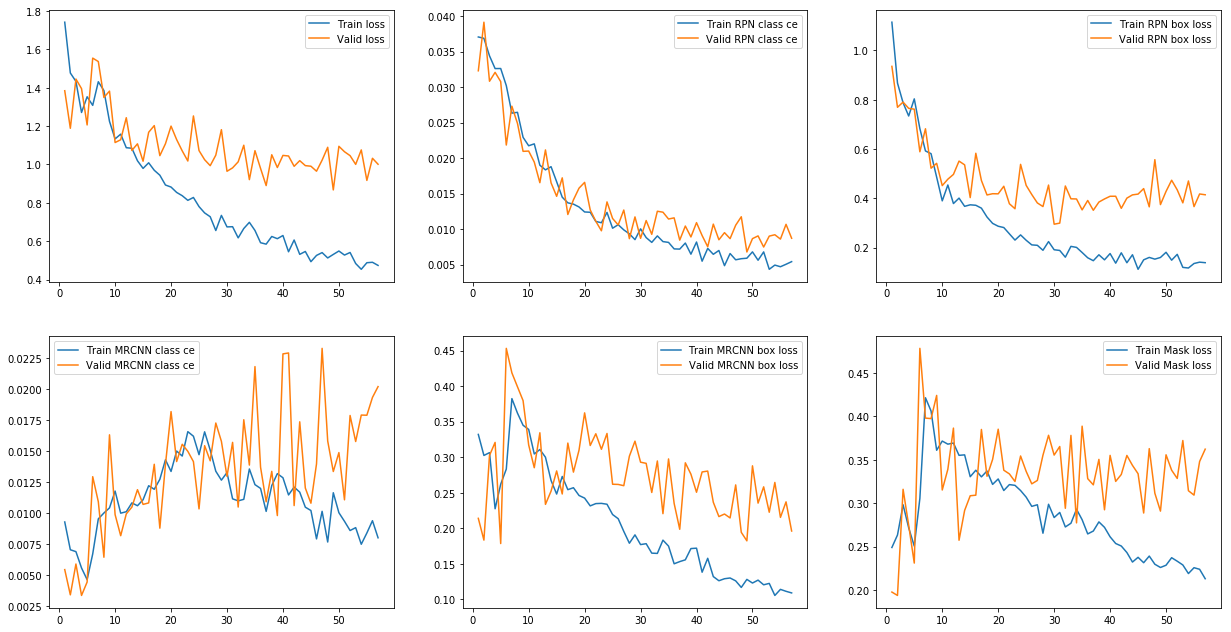

In [13]:
epochs = range(1, len(history['loss'])+1)
plt.figure(figsize=(21,11))

plt.subplot(231)
plt.plot(epochs, history["loss"], label="Train loss")
plt.plot(epochs, history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(232)
plt.plot(epochs, history["rpn_class_loss"], label="Train RPN class ce")
plt.plot(epochs, history["val_rpn_class_loss"], label="Valid RPN class ce")
plt.legend()
plt.subplot(233)
plt.plot(epochs, history["rpn_bbox_loss"], label="Train RPN box loss")
plt.plot(epochs, history["val_rpn_bbox_loss"], label="Valid RPN box loss")
plt.legend()
plt.subplot(234)
plt.plot(epochs, history["mrcnn_class_loss"], label="Train MRCNN class ce")
plt.plot(epochs, history["val_mrcnn_class_loss"], label="Valid MRCNN class ce")
plt.legend()
plt.subplot(235)
plt.plot(epochs, history["mrcnn_bbox_loss"], label="Train MRCNN box loss")
plt.plot(epochs, history["val_mrcnn_bbox_loss"], label="Valid MRCNN box loss")
plt.legend()
plt.subplot(236)
plt.plot(epochs, history["mrcnn_mask_loss"], label="Train Mask loss")
plt.plot(epochs, history["val_mrcnn_mask_loss"], label="Valid Mask loss")
plt.legend()

plt.show()

In [27]:
class InferenceConfig(cobbConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.75
inference_config = InferenceConfig()

# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference", 
                          config=inference_config,
                          model_dir=DATASET_DIR)

# Get path to saved weights
# Either set a specific path or find last trained weights
# model_path = os.path.join(ROOT_DIR, ".h5 file name here")
model_path=r"C:\projects\landClassification\inletMRCNN\cobb20200223T2101\mask_rcnn_cobb_0056.h5"
#model_path = model.find_last()
# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\projects\landClassification\inletMRCNN\cobb20200223T2101\mask_rcnn_cobb_0056.h5
Re-starting from epoch 56


[0 1]
1
22
original_image           shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
image_meta               shape: (14,)                 min:    0.00000  max:  512.00000  int32
gt_class_id              shape: (1,)                  min:    1.00000  max:    1.00000  int32
gt_bbox                  shape: (1, 4)                min:  412.00000  max:  499.00000  int32
gt_mask                  shape: (512, 512, 1)         min:    0.00000  max:    1.00000  bool


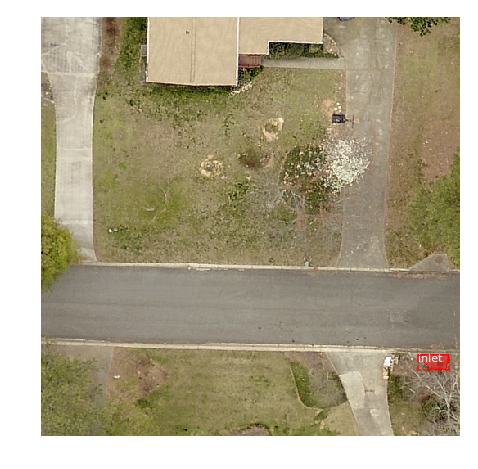

In [35]:
# Test on a random image
image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset_val, inference_config, 
                           image_id, use_mini_mask=False)
print (image_id)
log("original_image", original_image)
log("image_meta", image_meta)
log("gt_class_id", gt_class_id)
log("gt_bbox", gt_bbox)
log("gt_mask", gt_mask)
visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id, 
                            dataset.class_names, figsize=(8, 8))

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


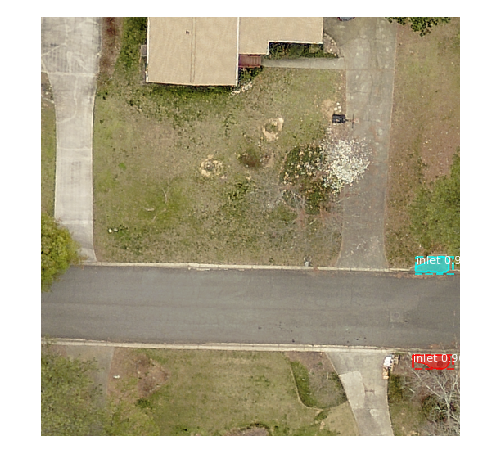

In [36]:
results = model.detect([original_image], verbose=1)

r = results[0]
visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'], 
                            dataset_val.class_names, r['scores'], ax=get_ax())

(3, 512, 512)


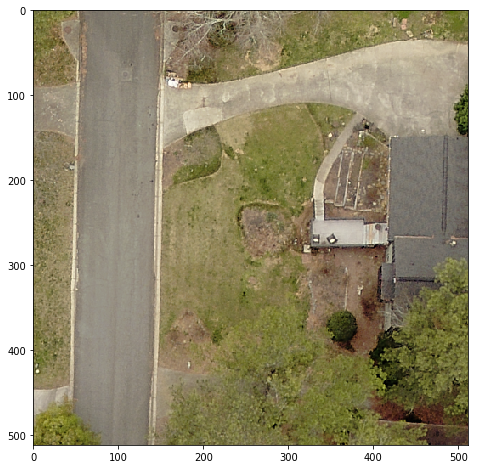

In [37]:
gtif=gdal.Open(os.path.join(DATASET_DIRVAL, "images/000001017.tif"))
img_arbitrary2 = np.array(gtif.ReadAsArray())
print(img_arbitrary2.shape)
img_show2=np.transpose(img_arbitrary2, [1,2,0])
f = plt.figure(figsize=(16,8))
implot=plt.imshow(img_show2)

Processing 1 images
image                    shape: (512, 512, 3)         min:    1.00000  max:  255.00000  uint8
molded_images            shape: (1, 512, 512, 3)      min: -122.70000  max:  147.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max:  512.00000  int32
anchors                  shape: (1, 65472, 4)         min:   -0.17712  max:    1.05188  float32


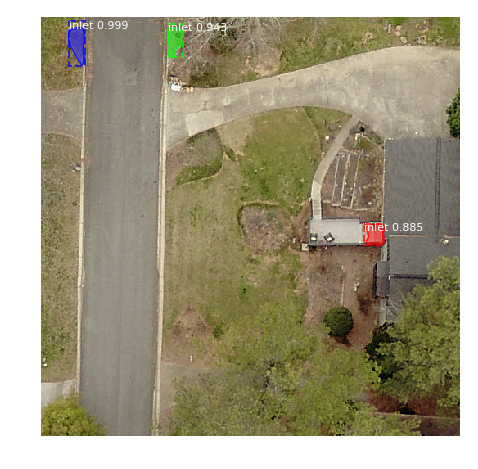

In [38]:
results2 = model.detect([img_show2], verbose=1)
r2 = results2[0]
visualize.display_instances(img_show2, r2['rois'], r2['masks'], r2['class_ids'], 
                            dataset_val.class_names, r2['scores'], ax=get_ax())

In [6]:
def get_cropped_data(image, bounds):
    a, b, c, d = bounds
    return np.asarray(image[:, int(a) : int((a + c)), int(b) : int(b + d)], dtype=np.float32)
def enumerate_squares(image, batch_size, block_size, xshift, yshift, padding=0):
    c, w, h = image.shape

    features = np.ones((int(batch_size), c, block_size, block_size), dtype=np.float32)
    coords = list(range(int(batch_size)))

    x_coords = [min((block_size - 2 * padding) * i, w - block_size) for i in
                range(int((w - padding) / (block_size - 2 * padding)))]
    y_coords = [min((block_size - 2 * padding) * i, h - block_size) for i in
                range(int((h - padding) / (block_size - 2 * padding)))]
    
    if (xshift>0):
        x_coords.append(w-block_size)
    if (yshift>0):
        y_coords.append(h-block_size)
    c_squares = 0
    for i in x_coords:
        for j in y_coords:
            bounds = (i, j, block_size, block_size)
            features[c_squares, :, :, :] = get_cropped_data(image, bounds)
            coords[c_squares] = (i, j)
            c_squares += 1
            if c_squares >= batch_size:
                yield c_squares, coords, features
                c_squares = 0

    if c_squares > 0:
        features = features[0:c_squares, :, :, :]
        yield c_squares, coords, features
        

def classify_tile(model, tile_data, output_data, block_size=512, batch_size=8):
    '''
tile_data is a numpy array of bytes of shape (c_input_channels, w, h)
output_data is a numpy array of bytes of shape (w, h)
    '''
    

    #block_size = 512  # TODO make non-hardcoded
    #input_channels, classes, padding = get_train_info(model)
    padding=0
    c,w,h=tile_data.shape
    wshift=0
    hshift=0
    batch_size_w=int(w/block_size)
    batch_size_h=int(h/block_size)    
    if (w % block_size!=0):
        
        wshift=w-batch_size_w*block_size
        batch_size_w+=1
    if (h % block_size!=0):
        
        hshift=h-batch_size_h*block_size
        batch_size_h+=1
    batch_size=batch_size_w * batch_size_h
    for size, coords, features in enumerate_squares(tile_data, batch_size, block_size, wshift, hshift, padding=0):
        predict_class = np.zeros((size,block_size, block_size, 1), dtype=np.uint8)
        #features are of size batch_size, channels, block_size, block_size
        img_input=np.rollaxis(features, 1, 4)
        for i in range(size):
            predict_class[i,:,:,:] = updatePixels(model,img_input[i,:,:,:])
    
#          predict_prob = model.predict(img_input)
#          #print(predict_prob1.shape)
#          #threshold predictions
#          predict_class = (predict_prob>0.5).astype(np.uint8).squeeze()  #predict_prob.argmax(axis = -1)
    predict_class = predict_class.astype(np.uint8).squeeze()
    for n in range(size):
            x, y = coords[n]
            temp=predict_class[n,:,:]
            output_data[ int(x+padding):int(x+block_size-padding), int(y+padding):int(y+block_size-padding)] = temp[ :, :]
    return predict_class, output_data

def updatePixels(model, image):
        results = model.detect([image], verbose=0)
        masks = results[0]['masks']
        class_ids = results[0]['class_ids']
#        visualize.display_instances(image, results[0]['rois'], masks, class_ids, 
#                            dataset_val.class_names, results[0]['scores'], ax=get_ax())
        output_raster = np.zeros((masks.shape[0], masks.shape[1], 1), dtype=np.uint8)
        mask_count = masks.shape[-1]
        for i in range(mask_count):
            mask = masks[:, :, i]
            output_raster[np.where(mask==True)] = class_ids[i]

        return output_raster #np.transpose(output_raster, [2,0,1])

In [7]:
# Let's define the standard  color palette
palette = {0 : (255, 255, 255), # Impervious surfaces (white)
           1 : (0, 0, 255),     # Buildings (blue)
           2 : (0, 255, 255),   # roads and parking lot (cyan)
           3 : (0, 255, 0),     # Vegetation (green)
           4 : (255, 255, 0),   #  (yellow)
           5 : (255, 0, 0),     #  (red)
           6 : (0, 0, 0)}       # barren (black)

invert_palette = {v: k for k, v in palette.items()}

def convert_to_color(arr_2d, palette=palette):
    """ Numeric labels to RGB-color encoding """
    arr_3d = np.zeros((arr_2d.shape[0], arr_2d.shape[1], 3), dtype=np.uint8)

    for c, i in palette.items():
        m = arr_2d == c
        arr_3d[m] = i

    return arr_3d

def convert_from_color(arr_3d, palette=invert_palette):
    """ RGB-color encoding to grayscale labels """
    arr_2d = np.zeros((arr_3d.shape[0], arr_3d.shape[1]), dtype=np.uint8)

    for c, i in palette.items():
        m = np.all(arr_3d == np.array(c).reshape(1, 1, 3), axis=2)
        arr_2d[m] = i

    return arr_2d


In [27]:
gtif = gdal.Open(r'C:\projects\landClassification\trains\2019_187450image\c187450.tif')

img_arbitrary = np.array(gtif.ReadAsArray())
print(img_arbitrary.shape)
img_show=np.rollaxis(img_arbitrary, 0, 3)

(3, 2202, 2320)


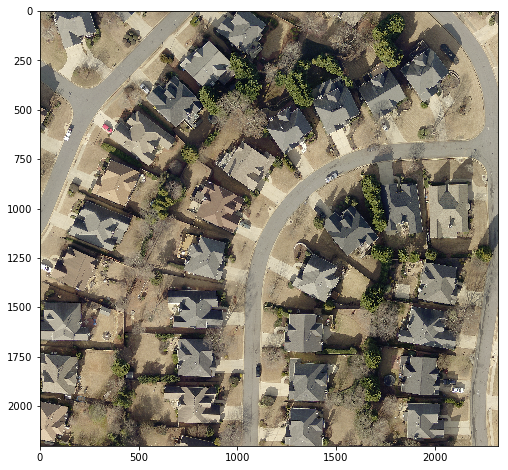

In [28]:
f = plt.figure(figsize=(16,8))
plt.imshow(img_show)
plt.show()

In [32]:
block_size=512
c,w,h=img_arbitrary.shape
num_classes = 1
output_data = np.zeros(( w, h), dtype=np.uint8)  # we want the probability of each class
bw=int(w/block_size)
bh=int(h/block_size)

In [34]:
predic_c, output_data= classify_tile(model, img_arbitrary, output_data, block_size=512, batch_size=(bw*bh))

In [35]:
colorimg=convert_to_color(output_data, palette=palette)

Text(0.5,1,'Prediction')

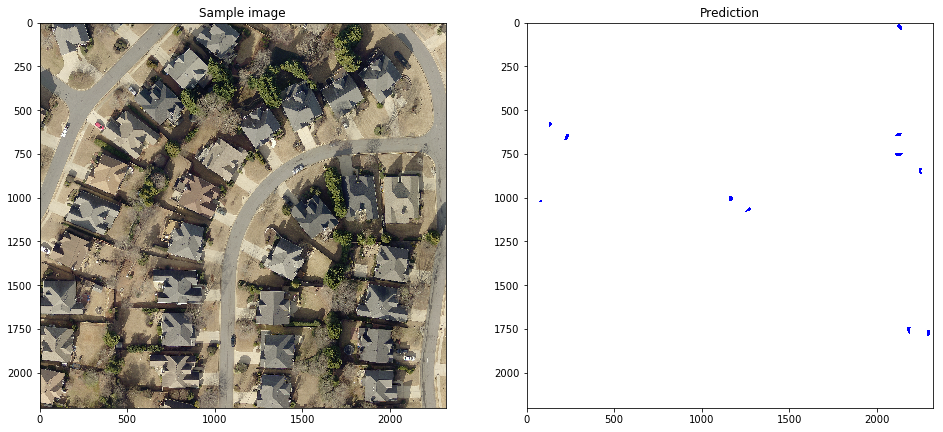

In [36]:
fig = plt.figure(figsize=(16,8))
a=fig.add_subplot(1,2,1)
implot=plt.imshow(img_show)

a.set_title('Sample image')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(colorimg)
#imgplot.set_clim(0.0, 0.7)
a.set_title('Prediction')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

In [46]:
io.imsave(r'C:\projects\landClassification\inletMRCNN\c197460_Clip.tif',output_data)

C:\Users\zhangc\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: C:\projects\landClassification\inletMRCNN\c197460_Clip.tif is a low contrast image
  warn('%s is a low contrast image' % fname)


In [51]:
gtif = gdal.Open(r'C:\projects\landClassification\trains\2019_187450image\187450.tif')

img_arbitrary1 = np.array(gtif.ReadAsArray())
print(img_arbitrary1.shape)
img_show1=np.rollaxis(img_arbitrary1, 0, 3)

(3, 20000, 20000)


In [52]:
f = plt.figure(figsize=(16,8))
#plt.imshow(img_show1)
#plt.show()

In [75]:
c,w1,h1=img_arbitrary1.shape
num_classes = 1
output_data1 = np.zeros(( w1, h1), dtype=np.uint8)  # we want the probability of each class
bw1=int(w1/block_size)
bh1=int(h1/block_size)

In [76]:
predic_c1, output_data1= classify_tile(model, img_arbitrary1, output_data1, block_size=512, batch_size=(bw1*bh1))

In [77]:
colorimg1=convert_to_color(output_data1, palette=palette)

Text(0.5,1,'Prediction')

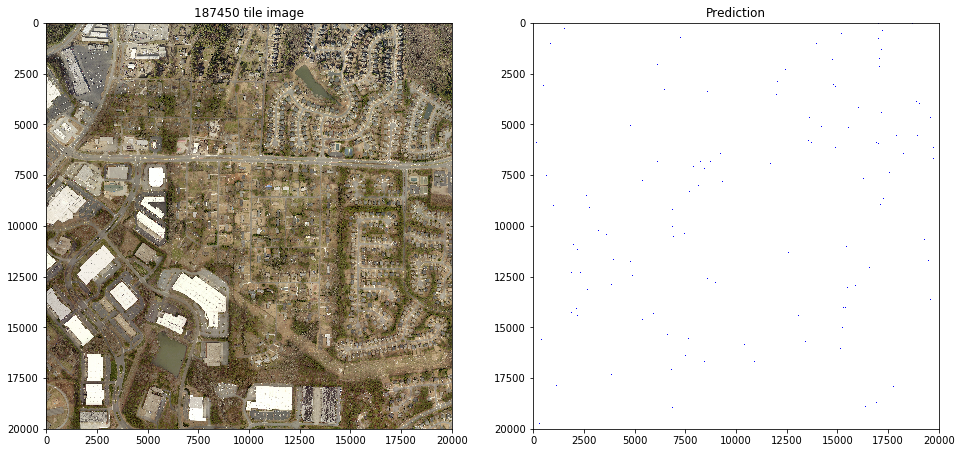

In [78]:
fig = plt.figure(figsize=(16,8))
a=fig.add_subplot(1,2,1)
implot=plt.imshow(img_show1)

a.set_title('187450 tile image')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')
a = fig.add_subplot(1, 2, 2)
imgplot = plt.imshow(colorimg1)
#imgplot.set_clim(0.0, 0.7)
a.set_title('Prediction')
#plt.colorbar(ticks=[0.1, 0.3, 0.5, 0.7], orientation='horizontal')

In [79]:
io.imsave(r'C:\projects\landClassification\inletMRCNN\187450_inletinfer75.tif',output_data1)

C:\Users\zhangc\AppData\Local\Continuum\anaconda3\lib\site-packages\skimage\io\_io.py:141: UserWarning: C:\projects\landClassification\inletMRCNN\187450_inletinfer75.tif is a low contrast image
  warn('%s is a low contrast image' % fname)
